#Multilingual text classification using Bag Of Words approach

For this notebook I choosed to use Keras + Tensorflow with some help from Scikit-Learn.

I got the dataset from [this repo](https://github.com/valeriano-manassero/multilingual-text-categorization-dataset).

In [1]:
import os
import urllib.request

folder_path = 'data'
file_path = folder_path + '/dataset.csv'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)

if not os.path.exists(file_path):
    file_url = 'https://github.com/valeriano-manassero/multilingual-text-categorization-dataset/raw/master/data/dataset.csv'
    with urllib.request.urlopen(file_url) as response, open(file_path, 'wb') as file:
        data = response.read()
        file.write(data)

First I need to load dataset shuffling rows.

In [2]:
import pandas as pd

data_df = pd.read_csv("data/dataset.csv", sep='\t', lineterminator='\n',
                      names=["language", "category", "text"])
data_df = data_df.sample(frac=1).reset_index(drop=True)
data_df.head(15)

,language,category,text
0,japanese,politics,報道によると、旅行者の身に着けている高級腕時計を盗むため、窃盗犯グループの一人がターゲットに...
1,turkish,health,"0İSTANBUL, (DHA)- KURBAN bayramına sayılı günl..."
2,greek,sports,Μήνυση έχει καταθέσει ο Κέβιν Γκαρνέτ κατά μια...
3,german,vehicles,Heiko Mania Mit der Smartfrog WLAN HD IP-Siche...
4,norwegian,tech,Les hele saken »Posten har nettopp mottatt sin...
5,spanish,entertainment,"Los cuatro gigantes tecnológicos —Apple, Googl..."
6,croatian,sports,Američka blogerka uporedila je Zagreb i Beogra...
7,japanese,marketing,20日に放送されたNHK「おげんさんといっしょ」に出演した三浦大知のパフォーマンスが話題とな...
8,japanese,shopping,はろーv(・∀・)先日、阪急百貨店様で行われたイベントの事をつらつらと書き留めたいと思います...
9,italian,travel,5 thriller per un’estate ad alta tensioneLi ab...


Looking at data, there are languages categories with small samples that can be not useful for our needs so I'm going to filter a bit.

In [3]:
filtered_languages = [
 'german',
 'spanish',
 'english',
 'french',
 'italian',
 'arabic',
 'russian',
 'albanian']

data_df = data_df[data_df['language'].isin(filtered_languages)]

filtered_categories = [
 'tech',
 'sports',
 'vehicles',
 'under_construction',
 'adult',
 'politics',
 'science',
 'illegal_content',
 'entertainment',
 'finance',
 'investing',
 'advertising',
 'religion',
 'hobbies_and_interests']

data_df = data_df[data_df['category'].isin(filtered_categories)]

At this stage I'm going to:
* remove all non alphanumeric chars and force lower case
* remove all digits
* remove small words (up to 3 chars)
* remove multiple spaces

After that, I'm going to merge language and categories to one label column.

In [4]:
import re

for index, row in data_df.iterrows():
    row['text'] = re.sub(r'[\W_]+', ' ', row['text'].lower(), flags=re.IGNORECASE | re.UNICODE)
    row['text'] = re.sub("\d+", "", row['text'])
    row['text'] = re.sub(r'\b\w{1,3}\b', '', row['text'])
    row['text'] = re.sub(' +', ' ', row['text'])

data_df['label'] = '(' + data_df['language'] + ') ' + data_df['category']
data_df.drop(columns=['language', 'category'], inplace=True)

data_df.head(15)

,text,label
3,heiko mania smartfrog wlan sicherheitskamera s...,(german) vehicles
5,cuatro gigantes tecnológicos apple google fac...,(spanish) entertainment
10,заседании минске представители попросили мину...,(russian) adult
13,diplômée institut supérieur gestion barbara co...,(french) vehicles
22,падение рубля прерванный штурм смотри американ...,(russian) entertainment
30,الألعاب مليئة بالأسرار التلميحات المخيفة المث...,(arabic) hobbies_and_interests
32,semana largo vuelve biomercado múltiples prop...,(spanish) politics
34,meine watchlist aktien medizintechnik unterne...,(german) investing
39,horoscope gémeaux vendredi gémeaux amour avec ...,(french) science
43,politische bibliothek google bereitet sich wa...,(german) entertainment


Now, I'm going to split dataset in training/testing. Since I want to be sure to have balanced datasets, I'm doing it manually instead of using Keras builtin methods.

In [5]:
counts = data_df['label'].value_counts()
data_df = data_df[~data_df['label'].isin(counts[counts < 100].index)]
labels = data_df['label'].unique().tolist()
num_labels = len(labels)

train_frac = 0.8

counter = 0
train_df, test_df = pd.DataFrame(), pd.DataFrame()

print("Total number of language/category combinations: ", len(labels))

for label in labels:
    counter += 1
    if counter % 10 == 0:
        print("Processed labels: ", counter)
    lbl_df = data_df[data_df["label"] == label]
    lbl_train_df = lbl_df.sample(frac=train_frac)
    lbl_test_df = lbl_df.drop(lbl_train_df.index)
    train_df = train_df.append(lbl_train_df)
    test_df = test_df.append(lbl_test_df)
print("Total labels processed: ", counter)

Total number of language/category combinations:  47
Processed labels:  10
Processed labels:  20
Processed labels:  30
Processed labels:  40
Total labels processed:  47


Time to use Tokenizer so I can get a vocabulary ready to go.

In [6]:
import numpy as np
from tensorflow import keras

tokenizer = keras.preprocessing.text.Tokenizer()
tokenizer.fit_on_texts(data_df['text'])

vocab_size = len(tokenizer.word_index)+1

print(vocab_size)

211230


Now getting Bag of Words matrixes for training dataset...

In [7]:
train_text_matrix = tokenizer.texts_to_matrix(train_df['text'], mode="tfidf")
print(train_text_matrix.shape)

(4784, 211230)


and testing dataset too.

In [8]:
train_test_matrix = tokenizer.texts_to_matrix(test_df['text'], mode="tfidf")
print(train_test_matrix.shape)

(1198, 211230)


Scikit have a nice LabelBinarizer really helpful to have a good form for final softmax on labels.

In [9]:
from sklearn.preprocessing import LabelBinarizer

lb = LabelBinarizer()
lb.fit(labels)
train_lb = lb.transform(train_df['label'])
test_lb = lb.transform(test_df['label'])

Now the Keras model with some Dense, Dropout and, finally a Softmax activation.

In [10]:
model = keras.models.Sequential()
model.add(keras.layers.Dense(64, input_shape=(vocab_size,)))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.3))
model.add(keras.layers.Dense(128))
model.add(keras.layers.Activation('relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(num_labels))
model.add(keras.layers.Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                13518784  
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               8320      
_________________________________________________________________
activation_1 (Activation)    (None, 128)               0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 47)                6063      
__________

Saving the tokenizer to file...

In [11]:
import pickle

folder_path = 'model'

if not os.path.exists(folder_path):
    os.makedirs(folder_path)
    
with open('model/tokenizer.pickle', 'wb') as handle:
    pickle.dump(tokenizer, handle, protocol=pickle.HIGHEST_PROTOCOL)

...and the LabelBinarizer. 

In [12]:
f = open("model/lb.pickle", "wb")
f.write(pickle.dumps(lb))
f.close()

Training time with a checkpoint to save best model.

In [13]:
epochs = 20
batch_size = 64

checkpoint = keras.callbacks.ModelCheckpoint('model/model.h5', verbose=1, monitor='val_loss',
                                             save_best_only=True, mode='auto')
model.compile(loss='categorical_crossentropy', optimizer='adagrad', metrics=["accuracy"])

H = model.fit(train_text_matrix, train_lb, epochs=epochs, batch_size=batch_size,
              validation_data=(train_test_matrix, test_lb), callbacks=[checkpoint])

Train on 4784 samples, validate on 1198 samples
Epoch 1/20


  64/4784 [..............................] - ETA: 1:21 - loss: 3.9110 - acc: 0.0000e+00

 128/4784 [..............................] - ETA: 44s - loss: 3.9400 - acc: 0.0156     

 192/4784 [>.............................] - ETA: 32s - loss: 3.9429 - acc: 0.0208

 256/4784 [>.............................] - ETA: 26s - loss: 3.9073 - acc: 0.0352

 320/4784 [=>............................] - ETA: 22s - loss: 3.8379 - acc: 0.0688

 384/4784 [=>............................] - ETA: 19s - loss: 3.8258 - acc: 0.0755

 448/4784 [=>............................] - ETA: 18s - loss: 3.7834 - acc: 0.0871

 512/4784 [==>...........................] - ETA: 16s - loss: 3.7532 - acc: 0.1055

 576/4784 [==>...........................] - ETA: 15s - loss: 3.7081 - acc: 0.1076

 640/4784 [===>..........................] - ETA: 14s - loss: 3.6963 - acc: 0.1187

 704/4784 [===>..........................] - ETA: 13s - loss: 3.6777 - acc: 0.1264

 768/4784 [===>..........................] - ETA: 13s - loss: 3.6366 - acc: 0.1341

 832/4784 [====>.........................] - ETA: 12s - loss: 3.5926 - acc: 0.1502

 896/4784 [====>.........................] - ETA: 11s - loss: 3.5458 - acc: 0.1607

 960/4784 [=====>........................] - ETA: 11s - loss: 3.5161 - acc: 0.1667

1024/4784 [=====>........................] - ETA: 11s - loss: 3.4985 - acc: 0.1719

1088/4784 [=====>........................] - ETA: 10s - loss: 3.4622 - acc: 0.1765

1152/4784 [======>.......................] - ETA: 10s - loss: 3.4553 - acc: 0.1762

1216/4784 [======>.......................] - ETA: 10s - loss: 3.4356 - acc: 0.1785

1280/4784 [=======>......................] - ETA: 9s - loss: 3.4281 - acc: 0.1789 

1344/4784 [=======>......................] - ETA: 9s - loss: 3.4007 - acc: 0.1860

1408/4784 [=======>......................] - ETA: 9s - loss: 3.3740 - acc: 0.1932

1472/4784 [========>.....................] - ETA: 8s - loss: 3.3466 - acc: 0.1990

1536/4784 [========>.....................] - ETA: 8s - loss: 3.3189 - acc: 0.2038

1600/4784 [=========>....................] - ETA: 8s - loss: 3.2963 - acc: 0.2094

1664/4784 [=========>....................] - ETA: 8s - loss: 3.2807 - acc: 0.2145

1728/4784 [=========>....................] - ETA: 7s - loss: 3.2508 - acc: 0.2211

1792/4784 [==========>...................] - ETA: 7s - loss: 3.2395 - acc: 0.2232

1856/4784 [==========>...................] - ETA: 7s - loss: 3.2121 - acc: 0.2274

1920/4784 [===========>..................] - ETA: 7s - loss: 3.1976 - acc: 0.2302

1984/4784 [===========>..................] - ETA: 6s - loss: 3.1767 - acc: 0.2334

2048/4784 [===========>..................] - ETA: 6s - loss: 3.1469 - acc: 0.2402

2112/4784 [============>.................] - ETA: 6s - loss: 3.1289 - acc: 0.2438

2176/4784 [============>.................] - ETA: 6s - loss: 3.1119 - acc: 0.2491

2240/4784 [=============>................] - ETA: 6s - loss: 3.1009 - acc: 0.2531

2304/4784 [=============>................] - ETA: 6s - loss: 3.0874 - acc: 0.2582

2368/4784 [=============>................] - ETA: 5s - loss: 3.0928 - acc: 0.2610

2432/4784 [==============>...............] - ETA: 5s - loss: 3.0764 - acc: 0.2640

2496/4784 [==============>...............] - ETA: 5s - loss: 3.0645 - acc: 0.2680

2560/4784 [===============>..............] - ETA: 5s - loss: 3.0527 - acc: 0.2699

2624/4784 [===============>..............] - ETA: 5s - loss: 3.0430 - acc: 0.2683

2688/4784 [===============>..............] - ETA: 4s - loss: 3.0328 - acc: 0.2734

2752/4784 [================>.............] - ETA: 4s - loss: 3.0140 - acc: 0.2783

2816/4784 [================>.............] - ETA: 4s - loss: 2.9953 - acc: 0.2827

2880/4784 [=================>............] - ETA: 4s - loss: 2.9815 - acc: 0.2854

2944/4784 [=================>............] - ETA: 4s - loss: 2.9682 - acc: 0.2880

3008/4784 [=================>............] - ETA: 4s - loss: 2.9561 - acc: 0.2906

3072/4784 [==================>...........] - ETA: 3s - loss: 2.9410 - acc: 0.2930

3136/4784 [==================>...........] - ETA: 3s - loss: 2.9229 - acc: 0.2959

3200/4784 [===================>..........] - ETA: 3s - loss: 2.9090 - acc: 0.2994

3264/4784 [===================>..........] - ETA: 3s - loss: 2.9021 - acc: 0.3009

3328/4784 [===================>..........] - ETA: 3s - loss: 2.8858 - acc: 0.3023

3392/4784 [====================>.........] - ETA: 3s - loss: 2.8675 - acc: 0.3066

3456/4784 [====================>.........] - ETA: 3s - loss: 2.8570 - acc: 0.3090

3520/4784 [=====================>........] - ETA: 2s - loss: 2.8474 - acc: 0.3111

3584/4784 [=====================>........] - ETA: 2s - loss: 2.8422 - acc: 0.3128

3648/4784 [=====================>........] - ETA: 2s - loss: 2.8262 - acc: 0.3169

3712/4784 [======================>.......] - ETA: 2s - loss: 2.8182 - acc: 0.3187

3776/4784 [======================>.......] - ETA: 2s - loss: 2.8072 - acc: 0.3210

3840/4784 [=======================>......] - ETA: 2s - loss: 2.7962 - acc: 0.3211

3904/4784 [=======================>......] - ETA: 1s - loss: 2.7917 - acc: 0.3222

3968/4784 [=======================>......] - ETA: 1s - loss: 2.7845 - acc: 0.3243

4032/4784 [========================>.....] - ETA: 1s - loss: 2.7813 - acc: 0.3256

4096/4784 [========================>.....] - ETA: 1s - loss: 2.7709 - acc: 0.3279

4160/4784 [=========================>....] - ETA: 1s - loss: 2.7607 - acc: 0.3310

4224/4784 [=========================>....] - ETA: 1s - loss: 2.7450 - acc: 0.3338

4288/4784 [=========================>....] - ETA: 1s - loss: 2.7307 - acc: 0.3368

4352/4784 [==========================>...] - ETA: 0s - loss: 2.7234 - acc: 0.3375

4416/4784 [==========================>...] - ETA: 0s - loss: 2.7176 - acc: 0.3388

4480/4784 [===========================>..] - ETA: 0s - loss: 2.7085 - acc: 0.3406

4544/4784 [===========================>..] - ETA: 0s - loss: 2.7011 - acc: 0.3418

4608/4784 [===========================>..] - ETA: 0s - loss: 2.6927 - acc: 0.3429

4672/4784 [============================>.] - ETA: 0s - loss: 2.6847 - acc: 0.3442

4736/4784 [============================>.] - ETA: 0s - loss: 2.6795 - acc: 0.3461


Epoch 00001: val_loss improved from inf to 1.25294, saving model to model/model.h5
4784/4784 [==============================] - 13s 3ms/step - loss: 2.6731 - acc: 0.3468 - val_loss: 1.2529 - val_acc: 0.7454


Epoch 2/20


  64/4784 [..............................] - ETA: 8s - loss: 2.3427 - acc: 0.5469

 128/4784 [..............................] - ETA: 8s - loss: 2.6270 - acc: 0.4688

 192/4784 [>.............................] - ETA: 8s - loss: 2.7002 - acc: 0.4688

 256/4784 [>.............................] - ETA: 7s - loss: 2.7170 - acc: 0.4648

 320/4784 [=>............................] - ETA: 7s - loss: 2.6253 - acc: 0.4813

 384/4784 [=>............................] - ETA: 7s - loss: 2.5209 - acc: 0.4818

 448/4784 [=>............................] - ETA: 7s - loss: 2.5560 - acc: 0.4888

 512/4784 [==>...........................] - ETA: 7s - loss: 2.5289 - acc: 0.4922

 576/4784 [==>...........................] - ETA: 7s - loss: 2.5033 - acc: 0.4896

 640/4784 [===>..........................] - ETA: 7s - loss: 2.4336 - acc: 0.5047

 704/4784 [===>..........................] - ETA: 6s - loss: 2.4103 - acc: 0.5043

 768/4784 [===>..........................] - ETA: 6s - loss: 2.4306 - acc: 0.5039

 832/4784 [====>.........................] - ETA: 6s - loss: 2.4522 - acc: 0.5000

 896/4784 [====>.........................] - ETA: 6s - loss: 2.4231 - acc: 0.5045

 960/4784 [=====>........................] - ETA: 6s - loss: 2.4142 - acc: 0.5052

1024/4784 [=====>........................] - ETA: 6s - loss: 2.3924 - acc: 0.5039

1088/4784 [=====>........................] - ETA: 6s - loss: 2.3836 - acc: 0.5028

1152/4784 [======>.......................] - ETA: 6s - loss: 2.3390 - acc: 0.5069

1216/4784 [======>.......................] - ETA: 6s - loss: 2.2952 - acc: 0.5107

1280/4784 [=======>......................] - ETA: 5s - loss: 2.2958 - acc: 0.5094

1344/4784 [=======>......................] - ETA: 5s - loss: 2.2990 - acc: 0.5126

1408/4784 [=======>......................] - ETA: 5s - loss: 2.2712 - acc: 0.5156

1472/4784 [========>.....................] - ETA: 5s - loss: 2.2482 - acc: 0.5197

1536/4784 [========>.....................] - ETA: 5s - loss: 2.2836 - acc: 0.5163

1600/4784 [=========>....................] - ETA: 5s - loss: 2.2655 - acc: 0.5175

1664/4784 [=========>....................] - ETA: 5s - loss: 2.2739 - acc: 0.5168

1728/4784 [=========>....................] - ETA: 5s - loss: 2.2885 - acc: 0.5162

1792/4784 [==========>...................] - ETA: 5s - loss: 2.2767 - acc: 0.5162

1856/4784 [==========>...................] - ETA: 4s - loss: 2.2699 - acc: 0.5183

1920/4784 [===========>..................] - ETA: 4s - loss: 2.2679 - acc: 0.5182

1984/4784 [===========>..................] - ETA: 4s - loss: 2.2840 - acc: 0.5197

2048/4784 [===========>..................] - ETA: 4s - loss: 2.2861 - acc: 0.5186

2112/4784 [============>.................] - ETA: 4s - loss: 2.3020 - acc: 0.5152

2176/4784 [============>.................] - ETA: 4s - loss: 2.3018 - acc: 0.5133

2240/4784 [=============>................] - ETA: 4s - loss: 2.2908 - acc: 0.5129

2304/4784 [=============>................] - ETA: 4s - loss: 2.2834 - acc: 0.5143

2368/4784 [=============>................] - ETA: 4s - loss: 2.2720 - acc: 0.5165

2432/4784 [==============>...............] - ETA: 3s - loss: 2.2729 - acc: 0.5164

2496/4784 [==============>...............] - ETA: 3s - loss: 2.2822 - acc: 0.5160

2560/4784 [===============>..............] - ETA: 3s - loss: 2.2629 - acc: 0.5199

2624/4784 [===============>..............] - ETA: 3s - loss: 2.2536 - acc: 0.5206

2688/4784 [===============>..............] - ETA: 3s - loss: 2.2464 - acc: 0.5201

2752/4784 [================>.............] - ETA: 3s - loss: 2.2344 - acc: 0.5214

2816/4784 [================>.............] - ETA: 3s - loss: 2.2312 - acc: 0.5227

2880/4784 [=================>............] - ETA: 3s - loss: 2.2153 - acc: 0.5243

2944/4784 [=================>............] - ETA: 3s - loss: 2.2223 - acc: 0.5228

3008/4784 [=================>............] - ETA: 3s - loss: 2.2208 - acc: 0.5236

3072/4784 [==================>...........] - ETA: 2s - loss: 2.2185 - acc: 0.5247

3136/4784 [==================>...........] - ETA: 2s - loss: 2.2110 - acc: 0.5242

3200/4784 [===================>..........] - ETA: 2s - loss: 2.1908 - acc: 0.5256

3264/4784 [===================>..........] - ETA: 2s - loss: 2.1948 - acc: 0.5267

3328/4784 [===================>..........] - ETA: 2s - loss: 2.1832 - acc: 0.5288

3392/4784 [====================>.........] - ETA: 2s - loss: 2.1662 - acc: 0.5321

3456/4784 [====================>.........] - ETA: 2s - loss: 2.1657 - acc: 0.5324

3520/4784 [=====================>........] - ETA: 2s - loss: 2.1658 - acc: 0.5332

3584/4784 [=====================>........] - ETA: 2s - loss: 2.1506 - acc: 0.5352

3648/4784 [=====================>........] - ETA: 1s - loss: 2.1502 - acc: 0.5332

3712/4784 [======================>.......] - ETA: 1s - loss: 2.1494 - acc: 0.5342

3776/4784 [======================>.......] - ETA: 1s - loss: 2.1512 - acc: 0.5352

3840/4784 [=======================>......] - ETA: 1s - loss: 2.1464 - acc: 0.5365

3904/4784 [=======================>......] - ETA: 1s - loss: 2.1378 - acc: 0.5371

3968/4784 [=======================>......] - ETA: 1s - loss: 2.1377 - acc: 0.5391

4032/4784 [========================>.....] - ETA: 1s - loss: 2.1253 - acc: 0.5409

4096/4784 [========================>.....] - ETA: 1s - loss: 2.1243 - acc: 0.5408

4160/4784 [=========================>....] - ETA: 1s - loss: 2.1292 - acc: 0.5401

4224/4784 [=========================>....] - ETA: 0s - loss: 2.1296 - acc: 0.5398

4288/4784 [=========================>....] - ETA: 0s - loss: 2.1265 - acc: 0.5387

4352/4784 [==========================>...] - ETA: 0s - loss: 2.1208 - acc: 0.5404

4416/4784 [==========================>...] - ETA: 0s - loss: 2.1278 - acc: 0.5385

4480/4784 [===========================>..] - ETA: 0s - loss: 2.1240 - acc: 0.5384

4544/4784 [===========================>..] - ETA: 0s - loss: 2.1157 - acc: 0.5383

4608/4784 [===========================>..] - ETA: 0s - loss: 2.1097 - acc: 0.5388

4672/4784 [============================>.] - ETA: 0s - loss: 2.1058 - acc: 0.5398

4736/4784 [============================>.] - ETA: 0s - loss: 2.1019 - acc: 0.5408


Epoch 00002: val_loss improved from 1.25294 to 1.03955, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 2.1026 - acc: 0.5406 - val_loss: 1.0396 - val_acc: 0.7796


Epoch 3/20
  64/4784 [..............................] - ETA: 8s - loss: 2.0478 - acc: 0.5312

 128/4784 [..............................] - ETA: 7s - loss: 2.1605 - acc: 0.5234

 192/4784 [>.............................] - ETA: 8s - loss: 1.9778 - acc: 0.5677

 256/4784 [>.............................] - ETA: 7s - loss: 1.8056 - acc: 0.6016

 320/4784 [=>............................] - ETA: 7s - loss: 1.7314 - acc: 0.6156

 384/4784 [=>............................] - ETA: 7s - loss: 1.7373 - acc: 0.6250

 448/4784 [=>............................] - ETA: 7s - loss: 1.6645 - acc: 0.6406

 512/4784 [==>...........................] - ETA: 7s - loss: 1.6601 - acc: 0.6387

 576/4784 [==>...........................] - ETA: 7s - loss: 1.6191 - acc: 0.6406

 640/4784 [===>..........................] - ETA: 7s - loss: 1.5843 - acc: 0.6438

 704/4784 [===>..........................] - ETA: 7s - loss: 1.5922 - acc: 0.6392

 768/4784 [===>..........................] - ETA: 6s - loss: 1.6289 - acc: 0.6276

 832/4784 [====>.........................] - ETA: 6s - loss: 1.6975 - acc: 0.6286

 896/4784 [====>.........................] - ETA: 6s - loss: 1.7007 - acc: 0.6306

 960/4784 [=====>........................] - ETA: 6s - loss: 1.6817 - acc: 0.6333

1024/4784 [=====>........................] - ETA: 6s - loss: 1.6819 - acc: 0.6318

1088/4784 [=====>........................] - ETA: 6s - loss: 1.6607 - acc: 0.6360

1152/4784 [======>.......................] - ETA: 6s - loss: 1.6595 - acc: 0.6328

1216/4784 [======>.......................] - ETA: 6s - loss: 1.7084 - acc: 0.6299

1280/4784 [=======>......................] - ETA: 5s - loss: 1.7359 - acc: 0.6305

1344/4784 [=======>......................] - ETA: 5s - loss: 1.7316 - acc: 0.6302

1408/4784 [=======>......................] - ETA: 5s - loss: 1.7359 - acc: 0.6314

1472/4784 [========>.....................] - ETA: 5s - loss: 1.7002 - acc: 0.6359

1536/4784 [========>.....................] - ETA: 5s - loss: 1.6750 - acc: 0.6387

1600/4784 [=========>....................] - ETA: 5s - loss: 1.6852 - acc: 0.6375

1664/4784 [=========>....................] - ETA: 5s - loss: 1.6838 - acc: 0.6352

1728/4784 [=========>....................] - ETA: 5s - loss: 1.6671 - acc: 0.6343

1792/4784 [==========>...................] - ETA: 5s - loss: 1.6787 - acc: 0.6339

1856/4784 [==========>...................] - ETA: 4s - loss: 1.6686 - acc: 0.6331

1920/4784 [===========>..................] - ETA: 4s - loss: 1.6593 - acc: 0.6344

1984/4784 [===========>..................] - ETA: 4s - loss: 1.6552 - acc: 0.6366

2048/4784 [===========>..................] - ETA: 4s - loss: 1.6668 - acc: 0.6338

2112/4784 [============>.................] - ETA: 4s - loss: 1.6680 - acc: 0.6316

2176/4784 [============>.................] - ETA: 4s - loss: 1.6646 - acc: 0.6324

2240/4784 [=============>................] - ETA: 4s - loss: 1.6583 - acc: 0.6308

2304/4784 [=============>................] - ETA: 4s - loss: 1.6533 - acc: 0.6341

2368/4784 [=============>................] - ETA: 4s - loss: 1.6621 - acc: 0.6347

2432/4784 [==============>...............] - ETA: 4s - loss: 1.6508 - acc: 0.6361

2496/4784 [==============>...............] - ETA: 3s - loss: 1.6493 - acc: 0.6358

2560/4784 [===============>..............] - ETA: 3s - loss: 1.6661 - acc: 0.6328

2624/4784 [===============>..............] - ETA: 3s - loss: 1.6735 - acc: 0.6326

2688/4784 [===============>..............] - ETA: 3s - loss: 1.6654 - acc: 0.6336

2752/4784 [================>.............] - ETA: 3s - loss: 1.6599 - acc: 0.6326

2816/4784 [================>.............] - ETA: 3s - loss: 1.6477 - acc: 0.6328

2880/4784 [=================>............] - ETA: 3s - loss: 1.6328 - acc: 0.6340

2944/4784 [=================>............] - ETA: 3s - loss: 1.6251 - acc: 0.6352

3008/4784 [=================>............] - ETA: 3s - loss: 1.6205 - acc: 0.6356

3072/4784 [==================>...........] - ETA: 2s - loss: 1.6225 - acc: 0.6344

3136/4784 [==================>...........] - ETA: 2s - loss: 1.6177 - acc: 0.6362

3200/4784 [===================>..........] - ETA: 2s - loss: 1.6179 - acc: 0.6356

3264/4784 [===================>..........] - ETA: 2s - loss: 1.6129 - acc: 0.6376

3328/4784 [===================>..........] - ETA: 2s - loss: 1.6052 - acc: 0.6391

3392/4784 [====================>.........] - ETA: 2s - loss: 1.5937 - acc: 0.6409

3456/4784 [====================>.........] - ETA: 2s - loss: 1.5867 - acc: 0.6409

3520/4784 [=====================>........] - ETA: 2s - loss: 1.5888 - acc: 0.6420

3584/4784 [=====================>........] - ETA: 2s - loss: 1.5855 - acc: 0.6431

3648/4784 [=====================>........] - ETA: 1s - loss: 1.5779 - acc: 0.6447

3712/4784 [======================>.......] - ETA: 1s - loss: 1.5754 - acc: 0.6455

3776/4784 [======================>.......] - ETA: 1s - loss: 1.5710 - acc: 0.6443

3840/4784 [=======================>......] - ETA: 1s - loss: 1.5690 - acc: 0.6456

3904/4784 [=======================>......] - ETA: 1s - loss: 1.5653 - acc: 0.6450

3968/4784 [=======================>......] - ETA: 1s - loss: 1.5502 - acc: 0.6474

4032/4784 [========================>.....] - ETA: 1s - loss: 1.5487 - acc: 0.6471

4096/4784 [========================>.....] - ETA: 1s - loss: 1.5396 - acc: 0.6484

4160/4784 [=========================>....] - ETA: 1s - loss: 1.5447 - acc: 0.6490

4224/4784 [=========================>....] - ETA: 0s - loss: 1.5442 - acc: 0.6489

4288/4784 [=========================>....] - ETA: 0s - loss: 1.5438 - acc: 0.6488

4352/4784 [==========================>...] - ETA: 0s - loss: 1.5340 - acc: 0.6500

4416/4784 [==========================>...] - ETA: 0s - loss: 1.5347 - acc: 0.6497

4480/4784 [===========================>..] - ETA: 0s - loss: 1.5363 - acc: 0.6482

4544/4784 [===========================>..] - ETA: 0s - loss: 1.5364 - acc: 0.6492

4608/4784 [===========================>..] - ETA: 0s - loss: 1.5342 - acc: 0.6495

4672/4784 [============================>.] - ETA: 0s - loss: 1.5290 - acc: 0.6500

4736/4784 [============================>.] - ETA: 0s - loss: 1.5257 - acc: 0.6508


Epoch 00003: val_loss improved from 1.03955 to 0.90005, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 1.5240 - acc: 0.6507 - val_loss: 0.9000 - val_acc: 0.8331


Epoch 4/20


  64/4784 [..............................] - ETA: 8s - loss: 0.9615 - acc: 0.7500

 128/4784 [..............................] - ETA: 8s - loss: 1.2056 - acc: 0.7031

 192/4784 [>.............................] - ETA: 8s - loss: 1.2790 - acc: 0.6927

 256/4784 [>.............................] - ETA: 8s - loss: 1.2087 - acc: 0.7031

 320/4784 [=>............................] - ETA: 8s - loss: 1.1016 - acc: 0.7375

 384/4784 [=>............................] - ETA: 7s - loss: 1.1500 - acc: 0.7344

 448/4784 [=>............................] - ETA: 7s - loss: 1.1912 - acc: 0.7366

 512/4784 [==>...........................] - ETA: 7s - loss: 1.1833 - acc: 0.7324

 576/4784 [==>...........................] - ETA: 7s - loss: 1.1880 - acc: 0.7292

 640/4784 [===>..........................] - ETA: 7s - loss: 1.2065 - acc: 0.7250

 704/4784 [===>..........................] - ETA: 7s - loss: 1.2141 - acc: 0.7173

 768/4784 [===>..........................] - ETA: 6s - loss: 1.2181 - acc: 0.7122

 832/4784 [====>.........................] - ETA: 6s - loss: 1.2232 - acc: 0.7103

 896/4784 [====>.........................] - ETA: 6s - loss: 1.2142 - acc: 0.7154

 960/4784 [=====>........................] - ETA: 6s - loss: 1.1980 - acc: 0.7198

1024/4784 [=====>........................] - ETA: 6s - loss: 1.2382 - acc: 0.7148

1088/4784 [=====>........................] - ETA: 6s - loss: 1.2234 - acc: 0.7151

1152/4784 [======>.......................] - ETA: 6s - loss: 1.2114 - acc: 0.7222

1216/4784 [======>.......................] - ETA: 6s - loss: 1.2458 - acc: 0.7163

1280/4784 [=======>......................] - ETA: 6s - loss: 1.2364 - acc: 0.7188

1344/4784 [=======>......................] - ETA: 5s - loss: 1.2532 - acc: 0.7188

1408/4784 [=======>......................] - ETA: 5s - loss: 1.2612 - acc: 0.7166

1472/4784 [========>.....................] - ETA: 5s - loss: 1.2519 - acc: 0.7147

1536/4784 [========>.....................] - ETA: 5s - loss: 1.2684 - acc: 0.7142

1600/4784 [=========>....................] - ETA: 5s - loss: 1.2627 - acc: 0.7175

1664/4784 [=========>....................] - ETA: 5s - loss: 1.2569 - acc: 0.7145

1728/4784 [=========>....................] - ETA: 5s - loss: 1.2610 - acc: 0.7118

1792/4784 [==========>...................] - ETA: 5s - loss: 1.2653 - acc: 0.7109

1856/4784 [==========>...................] - ETA: 4s - loss: 1.2492 - acc: 0.7155

1920/4784 [===========>..................] - ETA: 4s - loss: 1.2538 - acc: 0.7172

1984/4784 [===========>..................] - ETA: 4s - loss: 1.2517 - acc: 0.7167

2048/4784 [===========>..................] - ETA: 4s - loss: 1.2401 - acc: 0.7202

2112/4784 [============>.................] - ETA: 4s - loss: 1.2467 - acc: 0.7188

2176/4784 [============>.................] - ETA: 4s - loss: 1.2420 - acc: 0.7201

2240/4784 [=============>................] - ETA: 4s - loss: 1.2384 - acc: 0.7232

2304/4784 [=============>................] - ETA: 4s - loss: 1.2299 - acc: 0.7231

2368/4784 [=============>................] - ETA: 4s - loss: 1.2343 - acc: 0.7230

2432/4784 [==============>...............] - ETA: 4s - loss: 1.2274 - acc: 0.7233

2496/4784 [==============>...............] - ETA: 3s - loss: 1.2295 - acc: 0.7232

2560/4784 [===============>..............] - ETA: 3s - loss: 1.2369 - acc: 0.7223

2624/4784 [===============>..............] - ETA: 3s - loss: 1.2347 - acc: 0.7207

2688/4784 [===============>..............] - ETA: 3s - loss: 1.2271 - acc: 0.7206

2752/4784 [================>.............] - ETA: 3s - loss: 1.2188 - acc: 0.7217

2816/4784 [================>.............] - ETA: 3s - loss: 1.2073 - acc: 0.7241

2880/4784 [=================>............] - ETA: 3s - loss: 1.2098 - acc: 0.7236

2944/4784 [=================>............] - ETA: 3s - loss: 1.2222 - acc: 0.7225

3008/4784 [=================>............] - ETA: 3s - loss: 1.2268 - acc: 0.7227

3072/4784 [==================>...........] - ETA: 2s - loss: 1.2306 - acc: 0.7204

3136/4784 [==================>...........] - ETA: 2s - loss: 1.2239 - acc: 0.7210

3200/4784 [===================>..........] - ETA: 2s - loss: 1.2234 - acc: 0.7197

3264/4784 [===================>..........] - ETA: 2s - loss: 1.2145 - acc: 0.7194

3328/4784 [===================>..........] - ETA: 2s - loss: 1.2144 - acc: 0.7181

3392/4784 [====================>.........] - ETA: 2s - loss: 1.2163 - acc: 0.7182

3456/4784 [====================>.........] - ETA: 2s - loss: 1.2108 - acc: 0.7205

3520/4784 [=====================>........] - ETA: 2s - loss: 1.2126 - acc: 0.7210

3584/4784 [=====================>........] - ETA: 2s - loss: 1.2100 - acc: 0.7210

3648/4784 [=====================>........] - ETA: 1s - loss: 1.2032 - acc: 0.7220

3712/4784 [======================>.......] - ETA: 1s - loss: 1.2032 - acc: 0.7223

3776/4784 [======================>.......] - ETA: 1s - loss: 1.2088 - acc: 0.7217

3840/4784 [=======================>......] - ETA: 1s - loss: 1.2135 - acc: 0.7211

3904/4784 [=======================>......] - ETA: 1s - loss: 1.2079 - acc: 0.7211

3968/4784 [=======================>......] - ETA: 1s - loss: 1.2081 - acc: 0.7200

4032/4784 [========================>.....] - ETA: 1s - loss: 1.2169 - acc: 0.7197

4096/4784 [========================>.....] - ETA: 1s - loss: 1.2147 - acc: 0.7202

4160/4784 [=========================>....] - ETA: 1s - loss: 1.2046 - acc: 0.7226

4224/4784 [=========================>....] - ETA: 0s - loss: 1.2051 - acc: 0.7235

4288/4784 [=========================>....] - ETA: 0s - loss: 1.2142 - acc: 0.7225

4352/4784 [==========================>...] - ETA: 0s - loss: 1.2133 - acc: 0.7229

4416/4784 [==========================>...] - ETA: 0s - loss: 1.2078 - acc: 0.7237

4480/4784 [===========================>..] - ETA: 0s - loss: 1.2073 - acc: 0.7237

4544/4784 [===========================>..] - ETA: 0s - loss: 1.2093 - acc: 0.7223

4608/4784 [===========================>..] - ETA: 0s - loss: 1.2121 - acc: 0.7233

4672/4784 [============================>.] - ETA: 0s - loss: 1.2084 - acc: 0.7243

4736/4784 [============================>.] - ETA: 0s - loss: 1.2056 - acc: 0.7242


Epoch 00004: val_loss improved from 0.90005 to 0.80445, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 1.2065 - acc: 0.7230 - val_loss: 0.8045 - val_acc: 0.8464


Epoch 5/20
  64/4784 [..............................] - ETA: 7s - loss: 1.2744 - acc: 0.6719

 128/4784 [..............................] - ETA: 7s - loss: 1.3094 - acc: 0.6875

 192/4784 [>.............................] - ETA: 7s - loss: 1.1768 - acc: 0.7083

 256/4784 [>.............................] - ETA: 7s - loss: 1.1798 - acc: 0.7305

 320/4784 [=>............................] - ETA: 7s - loss: 1.2032 - acc: 0.7406

 384/4784 [=>............................] - ETA: 7s - loss: 1.1047 - acc: 0.7604

 448/4784 [=>............................] - ETA: 7s - loss: 1.1610 - acc: 0.7589

 512/4784 [==>...........................] - ETA: 7s - loss: 1.1011 - acc: 0.7637

 576/4784 [==>...........................] - ETA: 7s - loss: 1.0681 - acc: 0.7674

 640/4784 [===>..........................] - ETA: 7s - loss: 1.1631 - acc: 0.7578

 704/4784 [===>..........................] - ETA: 6s - loss: 1.1192 - acc: 0.7614

 768/4784 [===>..........................] - ETA: 6s - loss: 1.1019 - acc: 0.7695

 832/4784 [====>.........................] - ETA: 6s - loss: 1.0829 - acc: 0.7668

 896/4784 [====>.........................] - ETA: 6s - loss: 1.0711 - acc: 0.7667

 960/4784 [=====>........................] - ETA: 6s - loss: 1.0862 - acc: 0.7573

1024/4784 [=====>........................] - ETA: 6s - loss: 1.0852 - acc: 0.7529

1088/4784 [=====>........................] - ETA: 6s - loss: 1.0884 - acc: 0.7463

1152/4784 [======>.......................] - ETA: 6s - loss: 1.0782 - acc: 0.7500

1216/4784 [======>.......................] - ETA: 6s - loss: 1.0718 - acc: 0.7516

1280/4784 [=======>......................] - ETA: 5s - loss: 1.0734 - acc: 0.7508

1344/4784 [=======>......................] - ETA: 5s - loss: 1.0730 - acc: 0.7530

1408/4784 [=======>......................] - ETA: 5s - loss: 1.0590 - acc: 0.7557

1472/4784 [========>.....................] - ETA: 5s - loss: 1.0837 - acc: 0.7541

1536/4784 [========>.....................] - ETA: 5s - loss: 1.0889 - acc: 0.7565

1600/4784 [=========>....................] - ETA: 5s - loss: 1.0955 - acc: 0.7544

1664/4784 [=========>....................] - ETA: 5s - loss: 1.0871 - acc: 0.7542

1728/4784 [=========>....................] - ETA: 5s - loss: 1.0823 - acc: 0.7529

1792/4784 [==========>...................] - ETA: 5s - loss: 1.0683 - acc: 0.7539

1856/4784 [==========>...................] - ETA: 4s - loss: 1.0640 - acc: 0.7538

1920/4784 [===========>..................] - ETA: 4s - loss: 1.0611 - acc: 0.7542

1984/4784 [===========>..................] - ETA: 4s - loss: 1.0616 - acc: 0.7535

2048/4784 [===========>..................] - ETA: 4s - loss: 1.0729 - acc: 0.7505

2112/4784 [============>.................] - ETA: 4s - loss: 1.0599 - acc: 0.7524

2176/4784 [============>.................] - ETA: 4s - loss: 1.0537 - acc: 0.7528

2240/4784 [=============>................] - ETA: 4s - loss: 1.0605 - acc: 0.7527

2304/4784 [=============>................] - ETA: 4s - loss: 1.0550 - acc: 0.7522

2368/4784 [=============>................] - ETA: 4s - loss: 1.0474 - acc: 0.7538

2432/4784 [==============>...............] - ETA: 3s - loss: 1.0561 - acc: 0.7512

2496/4784 [==============>...............] - ETA: 3s - loss: 1.0806 - acc: 0.7500

2560/4784 [===============>..............] - ETA: 3s - loss: 1.0913 - acc: 0.7492

2624/4784 [===============>..............] - ETA: 3s - loss: 1.0963 - acc: 0.7496

2688/4784 [===============>..............] - ETA: 3s - loss: 1.1088 - acc: 0.7481

2752/4784 [================>.............] - ETA: 3s - loss: 1.0989 - acc: 0.7496

2816/4784 [================>.............] - ETA: 3s - loss: 1.0968 - acc: 0.7507

2880/4784 [=================>............] - ETA: 3s - loss: 1.0941 - acc: 0.7507

2944/4784 [=================>............] - ETA: 3s - loss: 1.0950 - acc: 0.7507

3008/4784 [=================>............] - ETA: 3s - loss: 1.0912 - acc: 0.7500

3072/4784 [==================>...........] - ETA: 2s - loss: 1.0997 - acc: 0.7474

3136/4784 [==================>...........] - ETA: 2s - loss: 1.1022 - acc: 0.7468

3200/4784 [===================>..........] - ETA: 2s - loss: 1.0988 - acc: 0.7475

3264/4784 [===================>..........] - ETA: 2s - loss: 1.0910 - acc: 0.7488

3328/4784 [===================>..........] - ETA: 2s - loss: 1.0873 - acc: 0.7494

3392/4784 [====================>.........] - ETA: 2s - loss: 1.0823 - acc: 0.7509

3456/4784 [====================>.........] - ETA: 2s - loss: 1.0775 - acc: 0.7520

3520/4784 [=====================>........] - ETA: 2s - loss: 1.0724 - acc: 0.7540

3584/4784 [=====================>........] - ETA: 2s - loss: 1.0636 - acc: 0.7547

3648/4784 [=====================>........] - ETA: 1s - loss: 1.0656 - acc: 0.7555

3712/4784 [======================>.......] - ETA: 1s - loss: 1.0687 - acc: 0.7535

3776/4784 [======================>.......] - ETA: 1s - loss: 1.0680 - acc: 0.7534

3840/4784 [=======================>......] - ETA: 1s - loss: 1.0599 - acc: 0.7552

3904/4784 [=======================>......] - ETA: 1s - loss: 1.0577 - acc: 0.7551

3968/4784 [=======================>......] - ETA: 1s - loss: 1.0641 - acc: 0.7553

4032/4784 [========================>.....] - ETA: 1s - loss: 1.0592 - acc: 0.7567

4096/4784 [========================>.....] - ETA: 1s - loss: 1.0548 - acc: 0.7576

4160/4784 [=========================>....] - ETA: 1s - loss: 1.0563 - acc: 0.7579

4224/4784 [=========================>....] - ETA: 0s - loss: 1.0546 - acc: 0.7585

4288/4784 [=========================>....] - ETA: 0s - loss: 1.0531 - acc: 0.7596

4352/4784 [==========================>...] - ETA: 0s - loss: 1.0554 - acc: 0.7585

4416/4784 [==========================>...] - ETA: 0s - loss: 1.0551 - acc: 0.7577

4480/4784 [===========================>..] - ETA: 0s - loss: 1.0495 - acc: 0.7583

4544/4784 [===========================>..] - ETA: 0s - loss: 1.0515 - acc: 0.7577

4608/4784 [===========================>..] - ETA: 0s - loss: 1.0550 - acc: 0.7580

4672/4784 [============================>.] - ETA: 0s - loss: 1.0478 - acc: 0.7590

4736/4784 [============================>.] - ETA: 0s - loss: 1.0399 - acc: 0.7608


Epoch 00005: val_loss improved from 0.80445 to 0.76176, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 1.0373 - acc: 0.7609 - val_loss: 0.7618 - val_acc: 0.8489


Epoch 6/20
  64/4784 [..............................] - ETA: 7s - loss: 1.2195 - acc: 0.6875

 128/4784 [..............................] - ETA: 7s - loss: 1.0336 - acc: 0.7188

 192/4784 [>.............................] - ETA: 7s - loss: 0.9487 - acc: 0.7500

 256/4784 [>.............................] - ETA: 7s - loss: 0.9625 - acc: 0.7578

 320/4784 [=>............................] - ETA: 7s - loss: 1.0050 - acc: 0.7531

 384/4784 [=>............................] - ETA: 7s - loss: 0.9881 - acc: 0.7630

 448/4784 [=>............................] - ETA: 7s - loss: 1.0131 - acc: 0.7612

 512/4784 [==>...........................] - ETA: 7s - loss: 0.9922 - acc: 0.7578

 576/4784 [==>...........................] - ETA: 7s - loss: 0.9662 - acc: 0.7656

 640/4784 [===>..........................] - ETA: 7s - loss: 0.9542 - acc: 0.7656

 704/4784 [===>..........................] - ETA: 6s - loss: 0.9726 - acc: 0.7642

 768/4784 [===>..........................] - ETA: 6s - loss: 1.0100 - acc: 0.7617

 832/4784 [====>.........................] - ETA: 6s - loss: 1.0156 - acc: 0.7632

 896/4784 [====>.........................] - ETA: 6s - loss: 1.0117 - acc: 0.7634

 960/4784 [=====>........................] - ETA: 6s - loss: 0.9939 - acc: 0.7667

1024/4784 [=====>........................] - ETA: 6s - loss: 0.9807 - acc: 0.7705

1088/4784 [=====>........................] - ETA: 6s - loss: 0.9808 - acc: 0.7702

1152/4784 [======>.......................] - ETA: 6s - loss: 0.9803 - acc: 0.7700

1216/4784 [======>.......................] - ETA: 6s - loss: 0.9901 - acc: 0.7656

1280/4784 [=======>......................] - ETA: 5s - loss: 0.9730 - acc: 0.7680

1344/4784 [=======>......................] - ETA: 5s - loss: 0.9759 - acc: 0.7656

1408/4784 [=======>......................] - ETA: 5s - loss: 0.9667 - acc: 0.7663

1472/4784 [========>.....................] - ETA: 5s - loss: 0.9537 - acc: 0.7697

1536/4784 [========>.....................] - ETA: 5s - loss: 0.9604 - acc: 0.7721

1600/4784 [=========>....................] - ETA: 5s - loss: 0.9449 - acc: 0.7762

1664/4784 [=========>....................] - ETA: 5s - loss: 0.9490 - acc: 0.7752

1728/4784 [=========>....................] - ETA: 5s - loss: 0.9472 - acc: 0.7737

1792/4784 [==========>...................] - ETA: 5s - loss: 0.9326 - acc: 0.7768

1856/4784 [==========>...................] - ETA: 4s - loss: 0.9345 - acc: 0.7786

1920/4784 [===========>..................] - ETA: 4s - loss: 0.9355 - acc: 0.7812

1984/4784 [===========>..................] - ETA: 4s - loss: 0.9208 - acc: 0.7848

2048/4784 [===========>..................] - ETA: 4s - loss: 0.9164 - acc: 0.7847

2112/4784 [============>.................] - ETA: 4s - loss: 0.9147 - acc: 0.7865

2176/4784 [============>.................] - ETA: 4s - loss: 0.9080 - acc: 0.7872

2240/4784 [=============>................] - ETA: 4s - loss: 0.8975 - acc: 0.7879

2304/4784 [=============>................] - ETA: 4s - loss: 0.8943 - acc: 0.7873

2368/4784 [=============>................] - ETA: 4s - loss: 0.8866 - acc: 0.7880

2432/4784 [==============>...............] - ETA: 3s - loss: 0.8814 - acc: 0.7874

2496/4784 [==============>...............] - ETA: 3s - loss: 0.8713 - acc: 0.7901

2560/4784 [===============>..............] - ETA: 3s - loss: 0.8710 - acc: 0.7898

2624/4784 [===============>..............] - ETA: 3s - loss: 0.8753 - acc: 0.7912

2688/4784 [===============>..............] - ETA: 3s - loss: 0.8741 - acc: 0.7898

2752/4784 [================>.............] - ETA: 3s - loss: 0.8699 - acc: 0.7896

2816/4784 [================>.............] - ETA: 3s - loss: 0.8661 - acc: 0.7898

2880/4784 [=================>............] - ETA: 3s - loss: 0.8559 - acc: 0.7920

2944/4784 [=================>............] - ETA: 3s - loss: 0.8588 - acc: 0.7911

3008/4784 [=================>............] - ETA: 2s - loss: 0.8650 - acc: 0.7912

3072/4784 [==================>...........] - ETA: 2s - loss: 0.8656 - acc: 0.7910

3136/4784 [==================>...........] - ETA: 2s - loss: 0.8638 - acc: 0.7899

3200/4784 [===================>..........] - ETA: 2s - loss: 0.8687 - acc: 0.7894

3264/4784 [===================>..........] - ETA: 2s - loss: 0.8610 - acc: 0.7911

3328/4784 [===================>..........] - ETA: 2s - loss: 0.8557 - acc: 0.7927

3392/4784 [====================>.........] - ETA: 2s - loss: 0.8539 - acc: 0.7922

3456/4784 [====================>.........] - ETA: 2s - loss: 0.8476 - acc: 0.7937

3520/4784 [=====================>........] - ETA: 2s - loss: 0.8501 - acc: 0.7935

3584/4784 [=====================>........] - ETA: 2s - loss: 0.8498 - acc: 0.7935

3648/4784 [=====================>........] - ETA: 1s - loss: 0.8503 - acc: 0.7939

3712/4784 [======================>.......] - ETA: 1s - loss: 0.8568 - acc: 0.7934

3776/4784 [======================>.......] - ETA: 1s - loss: 0.8533 - acc: 0.7937

3840/4784 [=======================>......] - ETA: 1s - loss: 0.8605 - acc: 0.7922

3904/4784 [=======================>......] - ETA: 1s - loss: 0.8623 - acc: 0.7920

3968/4784 [=======================>......] - ETA: 1s - loss: 0.8624 - acc: 0.7926

4032/4784 [========================>.....] - ETA: 1s - loss: 0.8594 - acc: 0.7929

4096/4784 [========================>.....] - ETA: 1s - loss: 0.8662 - acc: 0.7917

4160/4784 [=========================>....] - ETA: 1s - loss: 0.8672 - acc: 0.7916

4224/4784 [=========================>....] - ETA: 0s - loss: 0.8773 - acc: 0.7905

4288/4784 [=========================>....] - ETA: 0s - loss: 0.8854 - acc: 0.7901

4352/4784 [==========================>...] - ETA: 0s - loss: 0.8832 - acc: 0.7909

4416/4784 [==========================>...] - ETA: 0s - loss: 0.8870 - acc: 0.7908

4480/4784 [===========================>..] - ETA: 0s - loss: 0.8881 - acc: 0.7915

4544/4784 [===========================>..] - ETA: 0s - loss: 0.8883 - acc: 0.7916

4608/4784 [===========================>..] - ETA: 0s - loss: 0.8866 - acc: 0.7906

4672/4784 [============================>.] - ETA: 0s - loss: 0.8863 - acc: 0.7902

4736/4784 [============================>.] - ETA: 0s - loss: 0.8857 - acc: 0.7899


Epoch 00006: val_loss improved from 0.76176 to 0.73167, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.8816 - acc: 0.7908 - val_loss: 0.7317 - val_acc: 0.8523


Epoch 7/20
  64/4784 [..............................] - ETA: 7s - loss: 0.7259 - acc: 0.8125

 128/4784 [..............................] - ETA: 7s - loss: 0.6222 - acc: 0.8281

 192/4784 [>.............................] - ETA: 7s - loss: 0.7286 - acc: 0.8281

 256/4784 [>.............................] - ETA: 7s - loss: 0.7781 - acc: 0.8281

 320/4784 [=>............................] - ETA: 7s - loss: 0.8869 - acc: 0.8156

 384/4784 [=>............................] - ETA: 7s - loss: 0.9217 - acc: 0.8099

 448/4784 [=>............................] - ETA: 7s - loss: 0.9206 - acc: 0.8080

 512/4784 [==>...........................] - ETA: 7s - loss: 0.9099 - acc: 0.8066

 576/4784 [==>...........................] - ETA: 7s - loss: 0.8534 - acc: 0.8142

 640/4784 [===>..........................] - ETA: 7s - loss: 0.8582 - acc: 0.8156

 704/4784 [===>..........................] - ETA: 7s - loss: 0.8736 - acc: 0.8125

 768/4784 [===>..........................] - ETA: 6s - loss: 0.8643 - acc: 0.8086

 832/4784 [====>.........................] - ETA: 6s - loss: 0.8508 - acc: 0.8077

 896/4784 [====>.........................] - ETA: 6s - loss: 0.8470 - acc: 0.8092

 960/4784 [=====>........................] - ETA: 6s - loss: 0.8351 - acc: 0.8083

1024/4784 [=====>........................] - ETA: 6s - loss: 0.8340 - acc: 0.8037

1088/4784 [=====>........................] - ETA: 6s - loss: 0.8350 - acc: 0.8051

1152/4784 [======>.......................] - ETA: 6s - loss: 0.8493 - acc: 0.8030

1216/4784 [======>.......................] - ETA: 6s - loss: 0.8645 - acc: 0.7993

1280/4784 [=======>......................] - ETA: 5s - loss: 0.8670 - acc: 0.7992

1344/4784 [=======>......................] - ETA: 5s - loss: 0.8558 - acc: 0.8021

1408/4784 [=======>......................] - ETA: 5s - loss: 0.8497 - acc: 0.8004

1472/4784 [========>.....................] - ETA: 5s - loss: 0.8338 - acc: 0.8030

1536/4784 [========>.....................] - ETA: 5s - loss: 0.8387 - acc: 0.8027

1600/4784 [=========>....................] - ETA: 5s - loss: 0.8556 - acc: 0.8013

1664/4784 [=========>....................] - ETA: 5s - loss: 0.8473 - acc: 0.8017

1728/4784 [=========>....................] - ETA: 5s - loss: 0.8551 - acc: 0.8021

1792/4784 [==========>...................] - ETA: 5s - loss: 0.9009 - acc: 0.7985

1856/4784 [==========>...................] - ETA: 5s - loss: 0.9096 - acc: 0.7996

1920/4784 [===========>..................] - ETA: 4s - loss: 0.9150 - acc: 0.7979

1984/4784 [===========>..................] - ETA: 4s - loss: 0.8943 - acc: 0.8029

2048/4784 [===========>..................] - ETA: 4s - loss: 0.8812 - acc: 0.8047

2112/4784 [============>.................] - ETA: 4s - loss: 0.8766 - acc: 0.8063

2176/4784 [============>.................] - ETA: 4s - loss: 0.8696 - acc: 0.8070

2240/4784 [=============>................] - ETA: 4s - loss: 0.8713 - acc: 0.8071

2304/4784 [=============>................] - ETA: 4s - loss: 0.8612 - acc: 0.8082

2368/4784 [=============>................] - ETA: 4s - loss: 0.8664 - acc: 0.8087

2432/4784 [==============>...............] - ETA: 4s - loss: 0.8655 - acc: 0.8080

2496/4784 [==============>...............] - ETA: 3s - loss: 0.8600 - acc: 0.8077

2560/4784 [===============>..............] - ETA: 3s - loss: 0.8605 - acc: 0.8078

2624/4784 [===============>..............] - ETA: 3s - loss: 0.8562 - acc: 0.8079

2688/4784 [===============>..............] - ETA: 3s - loss: 0.8577 - acc: 0.8080

2752/4784 [================>.............] - ETA: 3s - loss: 0.8513 - acc: 0.8089

2816/4784 [================>.............] - ETA: 3s - loss: 0.8475 - acc: 0.8089

2880/4784 [=================>............] - ETA: 3s - loss: 0.8480 - acc: 0.8104

2944/4784 [=================>............] - ETA: 3s - loss: 0.8469 - acc: 0.8105

3008/4784 [=================>............] - ETA: 3s - loss: 0.8484 - acc: 0.8108

3072/4784 [==================>...........] - ETA: 2s - loss: 0.8437 - acc: 0.8115

3136/4784 [==================>...........] - ETA: 2s - loss: 0.8457 - acc: 0.8112

3200/4784 [===================>..........] - ETA: 2s - loss: 0.8462 - acc: 0.8100

3264/4784 [===================>..........] - ETA: 2s - loss: 0.8487 - acc: 0.8100

3328/4784 [===================>..........] - ETA: 2s - loss: 0.8511 - acc: 0.8101

3392/4784 [====================>.........] - ETA: 2s - loss: 0.8489 - acc: 0.8090

3456/4784 [====================>.........] - ETA: 2s - loss: 0.8466 - acc: 0.8090

3520/4784 [=====================>........] - ETA: 2s - loss: 0.8414 - acc: 0.8097

3584/4784 [=====================>........] - ETA: 2s - loss: 0.8444 - acc: 0.8092

3648/4784 [=====================>........] - ETA: 1s - loss: 0.8452 - acc: 0.8092

3712/4784 [======================>.......] - ETA: 1s - loss: 0.8465 - acc: 0.8095

3776/4784 [======================>.......] - ETA: 1s - loss: 0.8477 - acc: 0.8085

3840/4784 [=======================>......] - ETA: 1s - loss: 0.8438 - acc: 0.8086

3904/4784 [=======================>......] - ETA: 1s - loss: 0.8405 - acc: 0.8089

3968/4784 [=======================>......] - ETA: 1s - loss: 0.8400 - acc: 0.8100

4032/4784 [========================>.....] - ETA: 1s - loss: 0.8428 - acc: 0.8090

4096/4784 [========================>.....] - ETA: 1s - loss: 0.8418 - acc: 0.8093

4160/4784 [=========================>....] - ETA: 1s - loss: 0.8491 - acc: 0.8089

4224/4784 [=========================>....] - ETA: 0s - loss: 0.8490 - acc: 0.8092

4288/4784 [=========================>....] - ETA: 0s - loss: 0.8464 - acc: 0.8102

4352/4784 [==========================>...] - ETA: 0s - loss: 0.8404 - acc: 0.8114

4416/4784 [==========================>...] - ETA: 0s - loss: 0.8409 - acc: 0.8111

4480/4784 [===========================>..] - ETA: 0s - loss: 0.8386 - acc: 0.8114

4544/4784 [===========================>..] - ETA: 0s - loss: 0.8397 - acc: 0.8114

4608/4784 [===========================>..] - ETA: 0s - loss: 0.8368 - acc: 0.8118

4672/4784 [============================>.] - ETA: 0s - loss: 0.8348 - acc: 0.8121

4736/4784 [============================>.] - ETA: 0s - loss: 0.8324 - acc: 0.8117


Epoch 00007: val_loss improved from 0.73167 to 0.71316, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.8311 - acc: 0.8119 - val_loss: 0.7132 - val_acc: 0.8548


Epoch 8/20
  64/4784 [..............................] - ETA: 7s - loss: 0.6577 - acc: 0.8438

 128/4784 [..............................] - ETA: 7s - loss: 0.7401 - acc: 0.8203

 192/4784 [>.............................] - ETA: 7s - loss: 0.7885 - acc: 0.7917

 256/4784 [>.............................] - ETA: 7s - loss: 0.7807 - acc: 0.7930

 320/4784 [=>............................] - ETA: 7s - loss: 0.8333 - acc: 0.8063

 384/4784 [=>............................] - ETA: 7s - loss: 0.8322 - acc: 0.7969

 448/4784 [=>............................] - ETA: 7s - loss: 0.8592 - acc: 0.7991

 512/4784 [==>...........................] - ETA: 7s - loss: 0.8294 - acc: 0.8027

 576/4784 [==>...........................] - ETA: 7s - loss: 0.7863 - acc: 0.8090

 640/4784 [===>..........................] - ETA: 7s - loss: 0.7742 - acc: 0.8172

 704/4784 [===>..........................] - ETA: 7s - loss: 0.7669 - acc: 0.8139

 768/4784 [===>..........................] - ETA: 6s - loss: 0.7803 - acc: 0.8138

 832/4784 [====>.........................] - ETA: 6s - loss: 0.8152 - acc: 0.8077

 896/4784 [====>.........................] - ETA: 6s - loss: 0.8414 - acc: 0.8069

 960/4784 [=====>........................] - ETA: 6s - loss: 0.8441 - acc: 0.8094

1024/4784 [=====>........................] - ETA: 6s - loss: 0.8513 - acc: 0.8105

1088/4784 [=====>........................] - ETA: 6s - loss: 0.8754 - acc: 0.8107

1152/4784 [======>.......................] - ETA: 6s - loss: 0.8520 - acc: 0.8151

1216/4784 [======>.......................] - ETA: 6s - loss: 0.8379 - acc: 0.8183

1280/4784 [=======>......................] - ETA: 5s - loss: 0.8458 - acc: 0.8164

1344/4784 [=======>......................] - ETA: 5s - loss: 0.8321 - acc: 0.8170

1408/4784 [=======>......................] - ETA: 5s - loss: 0.8185 - acc: 0.8210

1472/4784 [========>.....................] - ETA: 5s - loss: 0.7981 - acc: 0.8240

1536/4784 [========>.....................] - ETA: 5s - loss: 0.8062 - acc: 0.8236

1600/4784 [=========>....................] - ETA: 5s - loss: 0.7860 - acc: 0.8275

1664/4784 [=========>....................] - ETA: 5s - loss: 0.7809 - acc: 0.8275

1728/4784 [=========>....................] - ETA: 5s - loss: 0.7711 - acc: 0.8287

1792/4784 [==========>...................] - ETA: 5s - loss: 0.7831 - acc: 0.8259

1856/4784 [==========>...................] - ETA: 4s - loss: 0.7795 - acc: 0.8281

1920/4784 [===========>..................] - ETA: 4s - loss: 0.7955 - acc: 0.8281

1984/4784 [===========>..................] - ETA: 4s - loss: 0.7862 - acc: 0.8286

2048/4784 [===========>..................] - ETA: 4s - loss: 0.7931 - acc: 0.8291

2112/4784 [============>.................] - ETA: 4s - loss: 0.7819 - acc: 0.8314

2176/4784 [============>.................] - ETA: 4s - loss: 0.7747 - acc: 0.8323

2240/4784 [=============>................] - ETA: 4s - loss: 0.7729 - acc: 0.8304

2304/4784 [=============>................] - ETA: 4s - loss: 0.7742 - acc: 0.8303

2368/4784 [=============>................] - ETA: 4s - loss: 0.7741 - acc: 0.8294

2432/4784 [==============>...............] - ETA: 3s - loss: 0.7741 - acc: 0.8277

2496/4784 [==============>...............] - ETA: 3s - loss: 0.7746 - acc: 0.8277

2560/4784 [===============>..............] - ETA: 3s - loss: 0.7686 - acc: 0.8277

2624/4784 [===============>..............] - ETA: 3s - loss: 0.7675 - acc: 0.8289

2688/4784 [===============>..............] - ETA: 3s - loss: 0.7623 - acc: 0.8300

2752/4784 [================>.............] - ETA: 3s - loss: 0.7560 - acc: 0.8307

2816/4784 [================>.............] - ETA: 3s - loss: 0.7532 - acc: 0.8306

2880/4784 [=================>............] - ETA: 3s - loss: 0.7582 - acc: 0.8316

2944/4784 [=================>............] - ETA: 3s - loss: 0.7566 - acc: 0.8322

3008/4784 [=================>............] - ETA: 3s - loss: 0.7672 - acc: 0.8311

3072/4784 [==================>...........] - ETA: 2s - loss: 0.7686 - acc: 0.8314

3136/4784 [==================>...........] - ETA: 2s - loss: 0.7698 - acc: 0.8323

3200/4784 [===================>..........] - ETA: 2s - loss: 0.7675 - acc: 0.8319

3264/4784 [===================>..........] - ETA: 2s - loss: 0.7678 - acc: 0.8321

3328/4784 [===================>..........] - ETA: 2s - loss: 0.7673 - acc: 0.8308

3392/4784 [====================>.........] - ETA: 2s - loss: 0.7689 - acc: 0.8305

3456/4784 [====================>.........] - ETA: 2s - loss: 0.7722 - acc: 0.8307

3520/4784 [=====================>........] - ETA: 2s - loss: 0.7689 - acc: 0.8321

3584/4784 [=====================>........] - ETA: 2s - loss: 0.7668 - acc: 0.8323

3648/4784 [=====================>........] - ETA: 1s - loss: 0.7713 - acc: 0.8311

3712/4784 [======================>.......] - ETA: 1s - loss: 0.7770 - acc: 0.8311

3776/4784 [======================>.......] - ETA: 1s - loss: 0.7769 - acc: 0.8321

3840/4784 [=======================>......] - ETA: 1s - loss: 0.7807 - acc: 0.8320

3904/4784 [=======================>......] - ETA: 1s - loss: 0.7827 - acc: 0.8322

3968/4784 [=======================>......] - ETA: 1s - loss: 0.7853 - acc: 0.8304

4032/4784 [========================>.....] - ETA: 1s - loss: 0.7853 - acc: 0.8299

4096/4784 [========================>.....] - ETA: 1s - loss: 0.7817 - acc: 0.8306

4160/4784 [=========================>....] - ETA: 1s - loss: 0.7769 - acc: 0.8310

4224/4784 [=========================>....] - ETA: 0s - loss: 0.7761 - acc: 0.8319

4288/4784 [=========================>....] - ETA: 0s - loss: 0.7738 - acc: 0.8321

4352/4784 [==========================>...] - ETA: 0s - loss: 0.7726 - acc: 0.8325

4416/4784 [==========================>...] - ETA: 0s - loss: 0.7737 - acc: 0.8324

4480/4784 [===========================>..] - ETA: 0s - loss: 0.7755 - acc: 0.8330

4544/4784 [===========================>..] - ETA: 0s - loss: 0.7768 - acc: 0.8321

4608/4784 [===========================>..] - ETA: 0s - loss: 0.7743 - acc: 0.8325

4672/4784 [============================>.] - ETA: 0s - loss: 0.7741 - acc: 0.8322

4736/4784 [============================>.] - ETA: 0s - loss: 0.7734 - acc: 0.8321


Epoch 00008: val_loss improved from 0.71316 to 0.68501, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.7697 - acc: 0.8326 - val_loss: 0.6850 - val_acc: 0.8531


Epoch 9/20
  64/4784 [..............................] - ETA: 7s - loss: 0.4611 - acc: 0.8594

 128/4784 [..............................] - ETA: 7s - loss: 0.5248 - acc: 0.8594

 192/4784 [>.............................] - ETA: 7s - loss: 0.5062 - acc: 0.8438

 256/4784 [>.............................] - ETA: 7s - loss: 0.5086 - acc: 0.8398

 320/4784 [=>............................] - ETA: 7s - loss: 0.5966 - acc: 0.8313

 384/4784 [=>............................] - ETA: 7s - loss: 0.5651 - acc: 0.8411

 448/4784 [=>............................] - ETA: 7s - loss: 0.5723 - acc: 0.8482

 512/4784 [==>...........................] - ETA: 7s - loss: 0.5621 - acc: 0.8438

 576/4784 [==>...........................] - ETA: 7s - loss: 0.5683 - acc: 0.8403

 640/4784 [===>..........................] - ETA: 7s - loss: 0.6003 - acc: 0.8453

 704/4784 [===>..........................] - ETA: 6s - loss: 0.6519 - acc: 0.8395

 768/4784 [===>..........................] - ETA: 6s - loss: 0.6508 - acc: 0.8398

 832/4784 [====>.........................] - ETA: 6s - loss: 0.6630 - acc: 0.8425

 896/4784 [====>.........................] - ETA: 6s - loss: 0.6628 - acc: 0.8438

 960/4784 [=====>........................] - ETA: 6s - loss: 0.6605 - acc: 0.8427

1024/4784 [=====>........................] - ETA: 6s - loss: 0.6622 - acc: 0.8398

1088/4784 [=====>........................] - ETA: 6s - loss: 0.6397 - acc: 0.8428

1152/4784 [======>.......................] - ETA: 6s - loss: 0.6560 - acc: 0.8446

1216/4784 [======>.......................] - ETA: 6s - loss: 0.6347 - acc: 0.8470

1280/4784 [=======>......................] - ETA: 5s - loss: 0.6412 - acc: 0.8477

1344/4784 [=======>......................] - ETA: 5s - loss: 0.6370 - acc: 0.8490

1408/4784 [=======>......................] - ETA: 5s - loss: 0.6453 - acc: 0.8466

1472/4784 [========>.....................] - ETA: 5s - loss: 0.6542 - acc: 0.8444

1536/4784 [========>.....................] - ETA: 5s - loss: 0.6639 - acc: 0.8398

1600/4784 [=========>....................] - ETA: 5s - loss: 0.6524 - acc: 0.8425

1664/4784 [=========>....................] - ETA: 5s - loss: 0.6439 - acc: 0.8450

1728/4784 [=========>....................] - ETA: 5s - loss: 0.6418 - acc: 0.8455

1792/4784 [==========>...................] - ETA: 5s - loss: 0.6399 - acc: 0.8443

1856/4784 [==========>...................] - ETA: 4s - loss: 0.6415 - acc: 0.8438

1920/4784 [===========>..................] - ETA: 4s - loss: 0.6333 - acc: 0.8443

1984/4784 [===========>..................] - ETA: 4s - loss: 0.6409 - acc: 0.8443

2048/4784 [===========>..................] - ETA: 4s - loss: 0.6376 - acc: 0.8447

2112/4784 [============>.................] - ETA: 4s - loss: 0.6280 - acc: 0.8456

2176/4784 [============>.................] - ETA: 4s - loss: 0.6307 - acc: 0.8447

2240/4784 [=============>................] - ETA: 4s - loss: 0.6343 - acc: 0.8451

2304/4784 [=============>................] - ETA: 4s - loss: 0.6407 - acc: 0.8446

2368/4784 [=============>................] - ETA: 4s - loss: 0.6398 - acc: 0.8454

2432/4784 [==============>...............] - ETA: 3s - loss: 0.6423 - acc: 0.8438

2496/4784 [==============>...............] - ETA: 3s - loss: 0.6501 - acc: 0.8421

2560/4784 [===============>..............] - ETA: 3s - loss: 0.6505 - acc: 0.8434

2624/4784 [===============>..............] - ETA: 3s - loss: 0.6447 - acc: 0.8457

2688/4784 [===============>..............] - ETA: 3s - loss: 0.6400 - acc: 0.8467

2752/4784 [================>.............] - ETA: 3s - loss: 0.6479 - acc: 0.8459

2816/4784 [================>.............] - ETA: 3s - loss: 0.6505 - acc: 0.8466

2880/4784 [=================>............] - ETA: 3s - loss: 0.6498 - acc: 0.8479

2944/4784 [=================>............] - ETA: 3s - loss: 0.6520 - acc: 0.8465

3008/4784 [=================>............] - ETA: 3s - loss: 0.6555 - acc: 0.8464

3072/4784 [==================>...........] - ETA: 2s - loss: 0.6529 - acc: 0.8467

3136/4784 [==================>...........] - ETA: 2s - loss: 0.6509 - acc: 0.8460

3200/4784 [===================>..........] - ETA: 2s - loss: 0.6577 - acc: 0.8456

3264/4784 [===================>..........] - ETA: 2s - loss: 0.6511 - acc: 0.8462

3328/4784 [===================>..........] - ETA: 2s - loss: 0.6585 - acc: 0.8459

3392/4784 [====================>.........] - ETA: 2s - loss: 0.6587 - acc: 0.8461

3456/4784 [====================>.........] - ETA: 2s - loss: 0.6635 - acc: 0.8461

3520/4784 [=====================>........] - ETA: 2s - loss: 0.6647 - acc: 0.8466

3584/4784 [=====================>........] - ETA: 2s - loss: 0.6603 - acc: 0.8477

3648/4784 [=====================>........] - ETA: 1s - loss: 0.6645 - acc: 0.8465

3712/4784 [======================>.......] - ETA: 1s - loss: 0.6661 - acc: 0.8475

3776/4784 [======================>.......] - ETA: 1s - loss: 0.6690 - acc: 0.8477

3840/4784 [=======================>......] - ETA: 1s - loss: 0.6642 - acc: 0.8484

3904/4784 [=======================>......] - ETA: 1s - loss: 0.6594 - acc: 0.8491

3968/4784 [=======================>......] - ETA: 1s - loss: 0.6580 - acc: 0.8498

4032/4784 [========================>.....] - ETA: 1s - loss: 0.6544 - acc: 0.8512

4096/4784 [========================>.....] - ETA: 1s - loss: 0.6500 - acc: 0.8518

4160/4784 [=========================>....] - ETA: 1s - loss: 0.6525 - acc: 0.8510

4224/4784 [=========================>....] - ETA: 0s - loss: 0.6521 - acc: 0.8511

4288/4784 [=========================>....] - ETA: 0s - loss: 0.6472 - acc: 0.8512

4352/4784 [==========================>...] - ETA: 0s - loss: 0.6427 - acc: 0.8523

4416/4784 [==========================>...] - ETA: 0s - loss: 0.6386 - acc: 0.8521

4480/4784 [===========================>..] - ETA: 0s - loss: 0.6404 - acc: 0.8518

4544/4784 [===========================>..] - ETA: 0s - loss: 0.6384 - acc: 0.8523

4608/4784 [===========================>..] - ETA: 0s - loss: 0.6431 - acc: 0.8518

4672/4784 [============================>.] - ETA: 0s - loss: 0.6424 - acc: 0.8523

4736/4784 [============================>.] - ETA: 0s - loss: 0.6405 - acc: 0.8526


Epoch 00009: val_loss improved from 0.68501 to 0.67394, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.6387 - acc: 0.8526 - val_loss: 0.6739 - val_acc: 0.8664


Epoch 10/20
  64/4784 [..............................] - ETA: 7s - loss: 0.3878 - acc: 0.8906

 128/4784 [..............................] - ETA: 7s - loss: 0.4421 - acc: 0.8984

 192/4784 [>.............................] - ETA: 7s - loss: 0.4629 - acc: 0.8958

 256/4784 [>.............................] - ETA: 7s - loss: 0.4874 - acc: 0.8906

 320/4784 [=>............................] - ETA: 7s - loss: 0.4734 - acc: 0.8906

 384/4784 [=>............................] - ETA: 7s - loss: 0.4660 - acc: 0.8932

 448/4784 [=>............................] - ETA: 7s - loss: 0.4687 - acc: 0.8906

 512/4784 [==>...........................] - ETA: 7s - loss: 0.4945 - acc: 0.8848

 576/4784 [==>...........................] - ETA: 7s - loss: 0.5166 - acc: 0.8837

 640/4784 [===>..........................] - ETA: 7s - loss: 0.5086 - acc: 0.8859

 704/4784 [===>..........................] - ETA: 6s - loss: 0.5389 - acc: 0.8778

 768/4784 [===>..........................] - ETA: 6s - loss: 0.5346 - acc: 0.8763

 832/4784 [====>.........................] - ETA: 6s - loss: 0.5342 - acc: 0.8750

 896/4784 [====>.........................] - ETA: 6s - loss: 0.5476 - acc: 0.8739

 960/4784 [=====>........................] - ETA: 6s - loss: 0.5281 - acc: 0.8802

1024/4784 [=====>........................] - ETA: 6s - loss: 0.5373 - acc: 0.8770

1088/4784 [=====>........................] - ETA: 6s - loss: 0.5515 - acc: 0.8750

1152/4784 [======>.......................] - ETA: 6s - loss: 0.5568 - acc: 0.8724

1216/4784 [======>.......................] - ETA: 6s - loss: 0.5584 - acc: 0.8725

1280/4784 [=======>......................] - ETA: 5s - loss: 0.5512 - acc: 0.8750

1344/4784 [=======>......................] - ETA: 5s - loss: 0.5472 - acc: 0.8750

1408/4784 [=======>......................] - ETA: 5s - loss: 0.5364 - acc: 0.8764

1472/4784 [========>.....................] - ETA: 5s - loss: 0.5419 - acc: 0.8736

1536/4784 [========>.....................] - ETA: 5s - loss: 0.5463 - acc: 0.8737

1600/4784 [=========>....................] - ETA: 5s - loss: 0.5519 - acc: 0.8738

1664/4784 [=========>....................] - ETA: 5s - loss: 0.5587 - acc: 0.8720

1728/4784 [=========>....................] - ETA: 5s - loss: 0.5649 - acc: 0.8709

1792/4784 [==========>...................] - ETA: 5s - loss: 0.5583 - acc: 0.8711

1856/4784 [==========>...................] - ETA: 4s - loss: 0.5499 - acc: 0.8723

1920/4784 [===========>..................] - ETA: 4s - loss: 0.5561 - acc: 0.8708

1984/4784 [===========>..................] - ETA: 4s - loss: 0.5496 - acc: 0.8725

2048/4784 [===========>..................] - ETA: 4s - loss: 0.5585 - acc: 0.8711

2112/4784 [============>.................] - ETA: 4s - loss: 0.5489 - acc: 0.8722

2176/4784 [============>.................] - ETA: 4s - loss: 0.5656 - acc: 0.8695

2240/4784 [=============>................] - ETA: 4s - loss: 0.5627 - acc: 0.8679

2304/4784 [=============>................] - ETA: 4s - loss: 0.5681 - acc: 0.8663

2368/4784 [=============>................] - ETA: 4s - loss: 0.5701 - acc: 0.8644

2432/4784 [==============>...............] - ETA: 3s - loss: 0.5705 - acc: 0.8643

2496/4784 [==============>...............] - ETA: 3s - loss: 0.5673 - acc: 0.8654

2560/4784 [===============>..............] - ETA: 3s - loss: 0.5701 - acc: 0.8645

2624/4784 [===============>..............] - ETA: 3s - loss: 0.5717 - acc: 0.8647

2688/4784 [===============>..............] - ETA: 3s - loss: 0.5813 - acc: 0.8642

2752/4784 [================>.............] - ETA: 3s - loss: 0.5862 - acc: 0.8641

2816/4784 [================>.............] - ETA: 3s - loss: 0.5799 - acc: 0.8658

2880/4784 [=================>............] - ETA: 3s - loss: 0.5746 - acc: 0.8667

2944/4784 [=================>............] - ETA: 3s - loss: 0.5701 - acc: 0.8672

3008/4784 [=================>............] - ETA: 3s - loss: 0.5802 - acc: 0.8660

3072/4784 [==================>...........] - ETA: 2s - loss: 0.5802 - acc: 0.8649

3136/4784 [==================>...........] - ETA: 2s - loss: 0.5838 - acc: 0.8642

3200/4784 [===================>..........] - ETA: 2s - loss: 0.5847 - acc: 0.8644

3264/4784 [===================>..........] - ETA: 2s - loss: 0.5861 - acc: 0.8640

3328/4784 [===================>..........] - ETA: 2s - loss: 0.5815 - acc: 0.8645

3392/4784 [====================>.........] - ETA: 2s - loss: 0.5908 - acc: 0.8644

3456/4784 [====================>.........] - ETA: 2s - loss: 0.5921 - acc: 0.8649

3520/4784 [=====================>........] - ETA: 2s - loss: 0.5872 - acc: 0.8659

3584/4784 [=====================>........] - ETA: 2s - loss: 0.5833 - acc: 0.8669

3648/4784 [=====================>........] - ETA: 1s - loss: 0.5853 - acc: 0.8668

3712/4784 [======================>.......] - ETA: 1s - loss: 0.5812 - acc: 0.8677

3776/4784 [======================>.......] - ETA: 1s - loss: 0.5865 - acc: 0.8673

3840/4784 [=======================>......] - ETA: 1s - loss: 0.5843 - acc: 0.8667

3904/4784 [=======================>......] - ETA: 1s - loss: 0.5817 - acc: 0.8673

3968/4784 [=======================>......] - ETA: 1s - loss: 0.5800 - acc: 0.8677

4032/4784 [========================>.....] - ETA: 1s - loss: 0.5782 - acc: 0.8678

4096/4784 [========================>.....] - ETA: 1s - loss: 0.5776 - acc: 0.8677

4160/4784 [=========================>....] - ETA: 1s - loss: 0.5791 - acc: 0.8673

4224/4784 [=========================>....] - ETA: 0s - loss: 0.5827 - acc: 0.8660

4288/4784 [=========================>....] - ETA: 0s - loss: 0.5886 - acc: 0.8652

4352/4784 [==========================>...] - ETA: 0s - loss: 0.5909 - acc: 0.8658

4416/4784 [==========================>...] - ETA: 0s - loss: 0.5946 - acc: 0.8659

4480/4784 [===========================>..] - ETA: 0s - loss: 0.5916 - acc: 0.8667

4544/4784 [===========================>..] - ETA: 0s - loss: 0.5892 - acc: 0.8666

4608/4784 [===========================>..] - ETA: 0s - loss: 0.5874 - acc: 0.8663

4672/4784 [============================>.] - ETA: 0s - loss: 0.5928 - acc: 0.8662

4736/4784 [============================>.] - ETA: 0s - loss: 0.5879 - acc: 0.8672


Epoch 00010: val_loss improved from 0.67394 to 0.67018, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.5898 - acc: 0.8671 - val_loss: 0.6702 - val_acc: 0.8589


Epoch 11/20


  64/4784 [..............................] - ETA: 8s - loss: 0.3994 - acc: 0.8906

 128/4784 [..............................] - ETA: 8s - loss: 0.3879 - acc: 0.8828

 192/4784 [>.............................] - ETA: 8s - loss: 0.4665 - acc: 0.8750

 256/4784 [>.............................] - ETA: 8s - loss: 0.4995 - acc: 0.8789

 320/4784 [=>............................] - ETA: 8s - loss: 0.4682 - acc: 0.8938

 384/4784 [=>............................] - ETA: 7s - loss: 0.4578 - acc: 0.8906

 448/4784 [=>............................] - ETA: 7s - loss: 0.4684 - acc: 0.8929

 512/4784 [==>...........................] - ETA: 7s - loss: 0.4921 - acc: 0.8867

 576/4784 [==>...........................] - ETA: 7s - loss: 0.5237 - acc: 0.8802

 640/4784 [===>..........................] - ETA: 7s - loss: 0.5177 - acc: 0.8812

 704/4784 [===>..........................] - ETA: 7s - loss: 0.5121 - acc: 0.8807

 768/4784 [===>..........................] - ETA: 7s - loss: 0.5229 - acc: 0.8815

 832/4784 [====>.........................] - ETA: 7s - loss: 0.5459 - acc: 0.8762

 896/4784 [====>.........................] - ETA: 7s - loss: 0.5379 - acc: 0.8772

 960/4784 [=====>........................] - ETA: 6s - loss: 0.5233 - acc: 0.8823

1024/4784 [=====>........................] - ETA: 6s - loss: 0.5290 - acc: 0.8809

1088/4784 [=====>........................] - ETA: 6s - loss: 0.5317 - acc: 0.8796

1152/4784 [======>.......................] - ETA: 6s - loss: 0.5315 - acc: 0.8802

1216/4784 [======>.......................] - ETA: 6s - loss: 0.5201 - acc: 0.8816

1280/4784 [=======>......................] - ETA: 6s - loss: 0.5456 - acc: 0.8781

1344/4784 [=======>......................] - ETA: 6s - loss: 0.5553 - acc: 0.8757

1408/4784 [=======>......................] - ETA: 6s - loss: 0.5513 - acc: 0.8764

1472/4784 [========>.....................] - ETA: 5s - loss: 0.5611 - acc: 0.8764

1536/4784 [========>.....................] - ETA: 5s - loss: 0.5565 - acc: 0.8776

1600/4784 [=========>....................] - ETA: 5s - loss: 0.5484 - acc: 0.8794

1664/4784 [=========>....................] - ETA: 5s - loss: 0.5440 - acc: 0.8804

1728/4784 [=========>....................] - ETA: 5s - loss: 0.5457 - acc: 0.8802

1792/4784 [==========>...................] - ETA: 5s - loss: 0.5372 - acc: 0.8811

1856/4784 [==========>...................] - ETA: 5s - loss: 0.5514 - acc: 0.8777

1920/4784 [===========>..................] - ETA: 5s - loss: 0.5548 - acc: 0.8771

1984/4784 [===========>..................] - ETA: 4s - loss: 0.5586 - acc: 0.8755

2048/4784 [===========>..................] - ETA: 4s - loss: 0.5585 - acc: 0.8745

2112/4784 [============>.................] - ETA: 4s - loss: 0.5619 - acc: 0.8736

2176/4784 [============>.................] - ETA: 4s - loss: 0.5547 - acc: 0.8741

2240/4784 [=============>................] - ETA: 4s - loss: 0.5691 - acc: 0.8714

2304/4784 [=============>................] - ETA: 4s - loss: 0.5654 - acc: 0.8711

2368/4784 [=============>................] - ETA: 4s - loss: 0.5710 - acc: 0.8708

2432/4784 [==============>...............] - ETA: 4s - loss: 0.5675 - acc: 0.8701

2496/4784 [==============>...............] - ETA: 3s - loss: 0.5662 - acc: 0.8710

2560/4784 [===============>..............] - ETA: 3s - loss: 0.5585 - acc: 0.8734

2624/4784 [===============>..............] - ETA: 3s - loss: 0.5596 - acc: 0.8731

2688/4784 [===============>..............] - ETA: 3s - loss: 0.5583 - acc: 0.8735

2752/4784 [================>.............] - ETA: 3s - loss: 0.5654 - acc: 0.8728

2816/4784 [================>.............] - ETA: 3s - loss: 0.5645 - acc: 0.8732

2880/4784 [=================>............] - ETA: 3s - loss: 0.5659 - acc: 0.8729

2944/4784 [=================>............] - ETA: 3s - loss: 0.5670 - acc: 0.8716

3008/4784 [=================>............] - ETA: 3s - loss: 0.5652 - acc: 0.8710

3072/4784 [==================>...........] - ETA: 2s - loss: 0.5645 - acc: 0.8714

3136/4784 [==================>...........] - ETA: 2s - loss: 0.5703 - acc: 0.8712

3200/4784 [===================>..........] - ETA: 2s - loss: 0.5671 - acc: 0.8709

3264/4784 [===================>..........] - ETA: 2s - loss: 0.5694 - acc: 0.8704

3328/4784 [===================>..........] - ETA: 2s - loss: 0.5692 - acc: 0.8705

3392/4784 [====================>.........] - ETA: 2s - loss: 0.5738 - acc: 0.8700

3456/4784 [====================>.........] - ETA: 2s - loss: 0.5735 - acc: 0.8701

3520/4784 [=====================>........] - ETA: 2s - loss: 0.5693 - acc: 0.8699

3584/4784 [=====================>........] - ETA: 2s - loss: 0.5659 - acc: 0.8705

3648/4784 [=====================>........] - ETA: 1s - loss: 0.5706 - acc: 0.8703

3712/4784 [======================>.......] - ETA: 1s - loss: 0.5717 - acc: 0.8696

3776/4784 [======================>.......] - ETA: 1s - loss: 0.5696 - acc: 0.8692

3840/4784 [=======================>......] - ETA: 1s - loss: 0.5672 - acc: 0.8698

3904/4784 [=======================>......] - ETA: 1s - loss: 0.5644 - acc: 0.8701

3968/4784 [=======================>......] - ETA: 1s - loss: 0.5682 - acc: 0.8697

4032/4784 [========================>.....] - ETA: 1s - loss: 0.5701 - acc: 0.8683

4096/4784 [========================>.....] - ETA: 1s - loss: 0.5733 - acc: 0.8674

4160/4784 [=========================>....] - ETA: 1s - loss: 0.5696 - acc: 0.8680

4224/4784 [=========================>....] - ETA: 0s - loss: 0.5667 - acc: 0.8686

4288/4784 [=========================>....] - ETA: 0s - loss: 0.5686 - acc: 0.8685

4352/4784 [==========================>...] - ETA: 0s - loss: 0.5673 - acc: 0.8679

4416/4784 [==========================>...] - ETA: 0s - loss: 0.5681 - acc: 0.8675

4480/4784 [===========================>..] - ETA: 0s - loss: 0.5669 - acc: 0.8679

4544/4784 [===========================>..] - ETA: 0s - loss: 0.5651 - acc: 0.8675

4608/4784 [===========================>..] - ETA: 0s - loss: 0.5636 - acc: 0.8672

4672/4784 [============================>.] - ETA: 0s - loss: 0.5592 - acc: 0.8677

4736/4784 [============================>.] - ETA: 0s - loss: 0.5578 - acc: 0.8676


Epoch 00011: val_loss improved from 0.67018 to 0.66157, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.5557 - acc: 0.8677 - val_loss: 0.6616 - val_acc: 0.8598


Epoch 12/20
  64/4784 [..............................] - ETA: 8s - loss: 0.7033 - acc: 0.8594

 128/4784 [..............................] - ETA: 8s - loss: 0.6591 - acc: 0.8438

 192/4784 [>.............................] - ETA: 7s - loss: 0.6267 - acc: 0.8385

 256/4784 [>.............................] - ETA: 7s - loss: 0.5561 - acc: 0.8555

 320/4784 [=>............................] - ETA: 7s - loss: 0.5802 - acc: 0.8438

 384/4784 [=>............................] - ETA: 7s - loss: 0.5728 - acc: 0.8490

 448/4784 [=>............................] - ETA: 7s - loss: 0.6001 - acc: 0.8460

 512/4784 [==>...........................] - ETA: 7s - loss: 0.5765 - acc: 0.8516

 576/4784 [==>...........................] - ETA: 7s - loss: 0.5561 - acc: 0.8542

 640/4784 [===>..........................] - ETA: 7s - loss: 0.5556 - acc: 0.8562

 704/4784 [===>..........................] - ETA: 7s - loss: 0.5489 - acc: 0.8608

 768/4784 [===>..........................] - ETA: 6s - loss: 0.5386 - acc: 0.8633

 832/4784 [====>.........................] - ETA: 6s - loss: 0.5431 - acc: 0.8630

 896/4784 [====>.........................] - ETA: 6s - loss: 0.5376 - acc: 0.8605

 960/4784 [=====>........................] - ETA: 6s - loss: 0.5154 - acc: 0.8677

1024/4784 [=====>........................] - ETA: 6s - loss: 0.5135 - acc: 0.8682

1088/4784 [=====>........................] - ETA: 6s - loss: 0.5069 - acc: 0.8686

1152/4784 [======>.......................] - ETA: 6s - loss: 0.5032 - acc: 0.8681

1216/4784 [======>.......................] - ETA: 6s - loss: 0.5207 - acc: 0.8668

1280/4784 [=======>......................] - ETA: 6s - loss: 0.5249 - acc: 0.8664

1344/4784 [=======>......................] - ETA: 5s - loss: 0.5189 - acc: 0.8683

1408/4784 [=======>......................] - ETA: 5s - loss: 0.5139 - acc: 0.8700

1472/4784 [========>.....................] - ETA: 5s - loss: 0.5133 - acc: 0.8702

1536/4784 [========>.....................] - ETA: 5s - loss: 0.5128 - acc: 0.8711

1600/4784 [=========>....................] - ETA: 5s - loss: 0.5212 - acc: 0.8688

1664/4784 [=========>....................] - ETA: 5s - loss: 0.5357 - acc: 0.8690

1728/4784 [=========>....................] - ETA: 5s - loss: 0.5311 - acc: 0.8686

1792/4784 [==========>...................] - ETA: 5s - loss: 0.5289 - acc: 0.8689

1856/4784 [==========>...................] - ETA: 5s - loss: 0.5233 - acc: 0.8696

1920/4784 [===========>..................] - ETA: 4s - loss: 0.5280 - acc: 0.8682

1984/4784 [===========>..................] - ETA: 4s - loss: 0.5266 - acc: 0.8705

2048/4784 [===========>..................] - ETA: 4s - loss: 0.5228 - acc: 0.8711

2112/4784 [============>.................] - ETA: 4s - loss: 0.5272 - acc: 0.8707

2176/4784 [============>.................] - ETA: 4s - loss: 0.5374 - acc: 0.8695

2240/4784 [=============>................] - ETA: 4s - loss: 0.5403 - acc: 0.8696

2304/4784 [=============>................] - ETA: 4s - loss: 0.5439 - acc: 0.8702

2368/4784 [=============>................] - ETA: 4s - loss: 0.5463 - acc: 0.8704

2432/4784 [==============>...............] - ETA: 4s - loss: 0.5425 - acc: 0.8709

2496/4784 [==============>...............] - ETA: 3s - loss: 0.5437 - acc: 0.8702

2560/4784 [===============>..............] - ETA: 3s - loss: 0.5416 - acc: 0.8703

2624/4784 [===============>..............] - ETA: 3s - loss: 0.5453 - acc: 0.8689

2688/4784 [===============>..............] - ETA: 3s - loss: 0.5394 - acc: 0.8698

2752/4784 [================>.............] - ETA: 3s - loss: 0.5402 - acc: 0.8695

2816/4784 [================>.............] - ETA: 3s - loss: 0.5365 - acc: 0.8707

2880/4784 [=================>............] - ETA: 3s - loss: 0.5335 - acc: 0.8708

2944/4784 [=================>............] - ETA: 3s - loss: 0.5316 - acc: 0.8713

3008/4784 [=================>............] - ETA: 3s - loss: 0.5304 - acc: 0.8720

3072/4784 [==================>...........] - ETA: 2s - loss: 0.5266 - acc: 0.8730

3136/4784 [==================>...........] - ETA: 2s - loss: 0.5244 - acc: 0.8728

3200/4784 [===================>..........] - ETA: 2s - loss: 0.5231 - acc: 0.8728

3264/4784 [===================>..........] - ETA: 2s - loss: 0.5274 - acc: 0.8713

3328/4784 [===================>..........] - ETA: 2s - loss: 0.5277 - acc: 0.8702

3392/4784 [====================>.........] - ETA: 2s - loss: 0.5290 - acc: 0.8703

3456/4784 [====================>.........] - ETA: 2s - loss: 0.5305 - acc: 0.8698

3520/4784 [=====================>........] - ETA: 2s - loss: 0.5334 - acc: 0.8707

3584/4784 [=====================>........] - ETA: 2s - loss: 0.5391 - acc: 0.8694

3648/4784 [=====================>........] - ETA: 1s - loss: 0.5420 - acc: 0.8690

3712/4784 [======================>.......] - ETA: 1s - loss: 0.5395 - acc: 0.8691

3776/4784 [======================>.......] - ETA: 1s - loss: 0.5378 - acc: 0.8694

3840/4784 [=======================>......] - ETA: 1s - loss: 0.5426 - acc: 0.8685

3904/4784 [=======================>......] - ETA: 1s - loss: 0.5395 - acc: 0.8681

3968/4784 [=======================>......] - ETA: 1s - loss: 0.5428 - acc: 0.8684

4032/4784 [========================>.....] - ETA: 1s - loss: 0.5480 - acc: 0.8683

4096/4784 [========================>.....] - ETA: 1s - loss: 0.5455 - acc: 0.8682

4160/4784 [=========================>....] - ETA: 1s - loss: 0.5466 - acc: 0.8683

4224/4784 [=========================>....] - ETA: 0s - loss: 0.5444 - acc: 0.8677

4288/4784 [=========================>....] - ETA: 0s - loss: 0.5433 - acc: 0.8675

4352/4784 [==========================>...] - ETA: 0s - loss: 0.5419 - acc: 0.8676

4416/4784 [==========================>...] - ETA: 0s - loss: 0.5429 - acc: 0.8675

4480/4784 [===========================>..] - ETA: 0s - loss: 0.5411 - acc: 0.8681

4544/4784 [===========================>..] - ETA: 0s - loss: 0.5419 - acc: 0.8680

4608/4784 [===========================>..] - ETA: 0s - loss: 0.5471 - acc: 0.8674

4672/4784 [============================>.] - ETA: 0s - loss: 0.5441 - acc: 0.8682

4736/4784 [============================>.] - ETA: 0s - loss: 0.5431 - acc: 0.8682


Epoch 00012: val_loss improved from 0.66157 to 0.64514, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.5435 - acc: 0.8681 - val_loss: 0.6451 - val_acc: 0.8648


Epoch 13/20


  64/4784 [..............................] - ETA: 8s - loss: 0.4664 - acc: 0.9062

 128/4784 [..............................] - ETA: 8s - loss: 0.4899 - acc: 0.8906

 192/4784 [>.............................] - ETA: 8s - loss: 0.4582 - acc: 0.9010

 256/4784 [>.............................] - ETA: 8s - loss: 0.6155 - acc: 0.8945

 320/4784 [=>............................] - ETA: 7s - loss: 0.6570 - acc: 0.8844

 384/4784 [=>............................] - ETA: 7s - loss: 0.6589 - acc: 0.8802

 448/4784 [=>............................] - ETA: 7s - loss: 0.6404 - acc: 0.8750

 512/4784 [==>...........................] - ETA: 7s - loss: 0.6217 - acc: 0.8730

 576/4784 [==>...........................] - ETA: 7s - loss: 0.5969 - acc: 0.8819

 640/4784 [===>..........................] - ETA: 7s - loss: 0.6138 - acc: 0.8797

 704/4784 [===>..........................] - ETA: 7s - loss: 0.5966 - acc: 0.8807

 768/4784 [===>..........................] - ETA: 7s - loss: 0.6272 - acc: 0.8776

 832/4784 [====>.........................] - ETA: 7s - loss: 0.6215 - acc: 0.8762

 896/4784 [====>.........................] - ETA: 6s - loss: 0.6026 - acc: 0.8795

 960/4784 [=====>........................] - ETA: 6s - loss: 0.5949 - acc: 0.8802

1024/4784 [=====>........................] - ETA: 6s - loss: 0.5878 - acc: 0.8799

1088/4784 [=====>........................] - ETA: 6s - loss: 0.5746 - acc: 0.8814

1152/4784 [======>.......................] - ETA: 6s - loss: 0.5620 - acc: 0.8837

1216/4784 [======>.......................] - ETA: 6s - loss: 0.5591 - acc: 0.8816

1280/4784 [=======>......................] - ETA: 6s - loss: 0.5473 - acc: 0.8844

1344/4784 [=======>......................] - ETA: 6s - loss: 0.5425 - acc: 0.8862

1408/4784 [=======>......................] - ETA: 5s - loss: 0.5479 - acc: 0.8842

1472/4784 [========>.....................] - ETA: 5s - loss: 0.5534 - acc: 0.8804

1536/4784 [========>.....................] - ETA: 5s - loss: 0.5557 - acc: 0.8789

1600/4784 [=========>....................] - ETA: 5s - loss: 0.5432 - acc: 0.8819

1664/4784 [=========>....................] - ETA: 5s - loss: 0.5350 - acc: 0.8822

1728/4784 [=========>....................] - ETA: 5s - loss: 0.5340 - acc: 0.8831

1792/4784 [==========>...................] - ETA: 5s - loss: 0.5309 - acc: 0.8845

1856/4784 [==========>...................] - ETA: 5s - loss: 0.5234 - acc: 0.8842

1920/4784 [===========>..................] - ETA: 5s - loss: 0.5199 - acc: 0.8844

1984/4784 [===========>..................] - ETA: 4s - loss: 0.5132 - acc: 0.8856

2048/4784 [===========>..................] - ETA: 4s - loss: 0.5070 - acc: 0.8867

2112/4784 [============>.................] - ETA: 4s - loss: 0.5054 - acc: 0.8868

2176/4784 [============>.................] - ETA: 4s - loss: 0.5065 - acc: 0.8874

2240/4784 [=============>................] - ETA: 4s - loss: 0.5098 - acc: 0.8862

2304/4784 [=============>................] - ETA: 4s - loss: 0.5069 - acc: 0.8859

2368/4784 [=============>................] - ETA: 4s - loss: 0.5065 - acc: 0.8856

2432/4784 [==============>...............] - ETA: 4s - loss: 0.5160 - acc: 0.8845

2496/4784 [==============>...............] - ETA: 3s - loss: 0.5152 - acc: 0.8838

2560/4784 [===============>..............] - ETA: 3s - loss: 0.5351 - acc: 0.8820

2624/4784 [===============>..............] - ETA: 3s - loss: 0.5364 - acc: 0.8811

2688/4784 [===============>..............] - ETA: 3s - loss: 0.5421 - acc: 0.8791

2752/4784 [================>.............] - ETA: 3s - loss: 0.5368 - acc: 0.8797

2816/4784 [================>.............] - ETA: 3s - loss: 0.5411 - acc: 0.8782

2880/4784 [=================>............] - ETA: 3s - loss: 0.5408 - acc: 0.8785

2944/4784 [=================>............] - ETA: 3s - loss: 0.5439 - acc: 0.8781

3008/4784 [=================>............] - ETA: 3s - loss: 0.5429 - acc: 0.8770

3072/4784 [==================>...........] - ETA: 2s - loss: 0.5447 - acc: 0.8760

3136/4784 [==================>...........] - ETA: 2s - loss: 0.5424 - acc: 0.8769

3200/4784 [===================>..........] - ETA: 2s - loss: 0.5439 - acc: 0.8766

3264/4784 [===================>..........] - ETA: 2s - loss: 0.5552 - acc: 0.8750

3328/4784 [===================>..........] - ETA: 2s - loss: 0.5516 - acc: 0.8753

3392/4784 [====================>.........] - ETA: 2s - loss: 0.5461 - acc: 0.8762

3456/4784 [====================>.........] - ETA: 2s - loss: 0.5457 - acc: 0.8762

3520/4784 [=====================>........] - ETA: 2s - loss: 0.5429 - acc: 0.8767

3584/4784 [=====================>........] - ETA: 2s - loss: 0.5457 - acc: 0.8764

3648/4784 [=====================>........] - ETA: 1s - loss: 0.5440 - acc: 0.8772

3712/4784 [======================>.......] - ETA: 1s - loss: 0.5415 - acc: 0.8772

3776/4784 [======================>.......] - ETA: 1s - loss: 0.5394 - acc: 0.8774

3840/4784 [=======================>......] - ETA: 1s - loss: 0.5422 - acc: 0.8773

3904/4784 [=======================>......] - ETA: 1s - loss: 0.5354 - acc: 0.8786

3968/4784 [=======================>......] - ETA: 1s - loss: 0.5303 - acc: 0.8793

4032/4784 [========================>.....] - ETA: 1s - loss: 0.5315 - acc: 0.8797

4096/4784 [========================>.....] - ETA: 1s - loss: 0.5281 - acc: 0.8809

4160/4784 [=========================>....] - ETA: 1s - loss: 0.5293 - acc: 0.8805

4224/4784 [=========================>....] - ETA: 0s - loss: 0.5267 - acc: 0.8809

4288/4784 [=========================>....] - ETA: 0s - loss: 0.5284 - acc: 0.8815

4352/4784 [==========================>...] - ETA: 0s - loss: 0.5272 - acc: 0.8812

4416/4784 [==========================>...] - ETA: 0s - loss: 0.5254 - acc: 0.8813

4480/4784 [===========================>..] - ETA: 0s - loss: 0.5288 - acc: 0.8810

4544/4784 [===========================>..] - ETA: 0s - loss: 0.5292 - acc: 0.8803

4608/4784 [===========================>..] - ETA: 0s - loss: 0.5281 - acc: 0.8798

4672/4784 [============================>.] - ETA: 0s - loss: 0.5273 - acc: 0.8808

4736/4784 [============================>.] - ETA: 0s - loss: 0.5267 - acc: 0.8805


Epoch 00013: val_loss did not improve from 0.64514
4784/4784 [==============================] - 10s 2ms/step - loss: 0.5290 - acc: 0.8804 - val_loss: 0.6485 - val_acc: 0.8673


Epoch 14/20
  64/4784 [..............................] - ETA: 7s - loss: 0.6190 - acc: 0.8594

 128/4784 [..............................] - ETA: 7s - loss: 0.6290 - acc: 0.8828

 192/4784 [>.............................] - ETA: 7s - loss: 0.5657 - acc: 0.8906

 256/4784 [>.............................] - ETA: 7s - loss: 0.5347 - acc: 0.8867

 320/4784 [=>............................] - ETA: 7s - loss: 0.5624 - acc: 0.8906

 384/4784 [=>............................] - ETA: 7s - loss: 0.5396 - acc: 0.8854

 448/4784 [=>............................] - ETA: 7s - loss: 0.5627 - acc: 0.8772

 512/4784 [==>...........................] - ETA: 7s - loss: 0.5370 - acc: 0.8770

 576/4784 [==>...........................] - ETA: 7s - loss: 0.5719 - acc: 0.8698

 640/4784 [===>..........................] - ETA: 7s - loss: 0.5713 - acc: 0.8672

 704/4784 [===>..........................] - ETA: 7s - loss: 0.5678 - acc: 0.8693

 768/4784 [===>..........................] - ETA: 7s - loss: 0.5475 - acc: 0.8711

 832/4784 [====>.........................] - ETA: 7s - loss: 0.5221 - acc: 0.8762

 896/4784 [====>.........................] - ETA: 7s - loss: 0.5185 - acc: 0.8783

 960/4784 [=====>........................] - ETA: 6s - loss: 0.5281 - acc: 0.8781

1024/4784 [=====>........................] - ETA: 6s - loss: 0.5136 - acc: 0.8779

1088/4784 [=====>........................] - ETA: 6s - loss: 0.5246 - acc: 0.8759

1152/4784 [======>.......................] - ETA: 6s - loss: 0.5296 - acc: 0.8767

1216/4784 [======>.......................] - ETA: 6s - loss: 0.5212 - acc: 0.8791

1280/4784 [=======>......................] - ETA: 6s - loss: 0.5208 - acc: 0.8781

1344/4784 [=======>......................] - ETA: 6s - loss: 0.5124 - acc: 0.8772

1408/4784 [=======>......................] - ETA: 6s - loss: 0.5037 - acc: 0.8800

1472/4784 [========>.....................] - ETA: 5s - loss: 0.4959 - acc: 0.8804

1536/4784 [========>.....................] - ETA: 5s - loss: 0.4988 - acc: 0.8796

1600/4784 [=========>....................] - ETA: 5s - loss: 0.5024 - acc: 0.8800

1664/4784 [=========>....................] - ETA: 5s - loss: 0.5002 - acc: 0.8816

1728/4784 [=========>....................] - ETA: 5s - loss: 0.5020 - acc: 0.8808

1792/4784 [==========>...................] - ETA: 5s - loss: 0.5038 - acc: 0.8811

1856/4784 [==========>...................] - ETA: 5s - loss: 0.5073 - acc: 0.8815

1920/4784 [===========>..................] - ETA: 5s - loss: 0.5074 - acc: 0.8802

1984/4784 [===========>..................] - ETA: 5s - loss: 0.5119 - acc: 0.8800

2048/4784 [===========>..................] - ETA: 4s - loss: 0.5055 - acc: 0.8804

2112/4784 [============>.................] - ETA: 4s - loss: 0.5142 - acc: 0.8802

2176/4784 [============>.................] - ETA: 4s - loss: 0.5234 - acc: 0.8778

2240/4784 [=============>................] - ETA: 4s - loss: 0.5265 - acc: 0.8777

2304/4784 [=============>................] - ETA: 4s - loss: 0.5260 - acc: 0.8772

2368/4784 [=============>................] - ETA: 4s - loss: 0.5232 - acc: 0.8780

2432/4784 [==============>...............] - ETA: 4s - loss: 0.5266 - acc: 0.8791

2496/4784 [==============>...............] - ETA: 4s - loss: 0.5309 - acc: 0.8782

2560/4784 [===============>..............] - ETA: 4s - loss: 0.5229 - acc: 0.8801

2624/4784 [===============>..............] - ETA: 3s - loss: 0.5193 - acc: 0.8811

2688/4784 [===============>..............] - ETA: 3s - loss: 0.5192 - acc: 0.8806

2752/4784 [================>.............] - ETA: 3s - loss: 0.5196 - acc: 0.8812

2816/4784 [================>.............] - ETA: 3s - loss: 0.5128 - acc: 0.8821

2880/4784 [=================>............] - ETA: 3s - loss: 0.5083 - acc: 0.8826

2944/4784 [=================>............] - ETA: 3s - loss: 0.5019 - acc: 0.8838

3008/4784 [=================>............] - ETA: 3s - loss: 0.5024 - acc: 0.8840

3072/4784 [==================>...........] - ETA: 3s - loss: 0.5001 - acc: 0.8844

3136/4784 [==================>...........] - ETA: 2s - loss: 0.4985 - acc: 0.8839

3200/4784 [===================>..........] - ETA: 2s - loss: 0.4966 - acc: 0.8844

3264/4784 [===================>..........] - ETA: 2s - loss: 0.4956 - acc: 0.8851

3328/4784 [===================>..........] - ETA: 2s - loss: 0.4921 - acc: 0.8864

3392/4784 [====================>.........] - ETA: 2s - loss: 0.4979 - acc: 0.8859

3456/4784 [====================>.........] - ETA: 2s - loss: 0.4994 - acc: 0.8860

3520/4784 [=====================>........] - ETA: 2s - loss: 0.5008 - acc: 0.8869

3584/4784 [=====================>........] - ETA: 2s - loss: 0.4985 - acc: 0.8864

3648/4784 [=====================>........] - ETA: 2s - loss: 0.4958 - acc: 0.8865

3712/4784 [======================>.......] - ETA: 1s - loss: 0.4942 - acc: 0.8860

3776/4784 [======================>.......] - ETA: 1s - loss: 0.4920 - acc: 0.8867

3840/4784 [=======================>......] - ETA: 1s - loss: 0.4969 - acc: 0.8859

3904/4784 [=======================>......] - ETA: 1s - loss: 0.4942 - acc: 0.8865

3968/4784 [=======================>......] - ETA: 1s - loss: 0.4910 - acc: 0.8868

4032/4784 [========================>.....] - ETA: 1s - loss: 0.4912 - acc: 0.8867

4096/4784 [========================>.....] - ETA: 1s - loss: 0.4903 - acc: 0.8865

4160/4784 [=========================>....] - ETA: 1s - loss: 0.4898 - acc: 0.8873

4224/4784 [=========================>....] - ETA: 0s - loss: 0.4910 - acc: 0.8864

4288/4784 [=========================>....] - ETA: 0s - loss: 0.4893 - acc: 0.8860

4352/4784 [==========================>...] - ETA: 0s - loss: 0.4960 - acc: 0.8856

4416/4784 [==========================>...] - ETA: 0s - loss: 0.5000 - acc: 0.8854

4480/4784 [===========================>..] - ETA: 0s - loss: 0.4976 - acc: 0.8857

4544/4784 [===========================>..] - ETA: 0s - loss: 0.4979 - acc: 0.8856

4608/4784 [===========================>..] - ETA: 0s - loss: 0.4953 - acc: 0.8854

4672/4784 [============================>.] - ETA: 0s - loss: 0.4989 - acc: 0.8848

4736/4784 [============================>.] - ETA: 0s - loss: 0.4958 - acc: 0.8851


Epoch 00014: val_loss did not improve from 0.64514
4784/4784 [==============================] - 10s 2ms/step - loss: 0.4943 - acc: 0.8852 - val_loss: 0.6454 - val_acc: 0.8639


Epoch 15/20
  64/4784 [..............................] - ETA: 8s - loss: 0.7233 - acc: 0.9062

 128/4784 [..............................] - ETA: 7s - loss: 0.5118 - acc: 0.9219

 192/4784 [>.............................] - ETA: 7s - loss: 0.4113 - acc: 0.9375

 256/4784 [>.............................] - ETA: 7s - loss: 0.3899 - acc: 0.9336

 320/4784 [=>............................] - ETA: 7s - loss: 0.4208 - acc: 0.9219

 384/4784 [=>............................] - ETA: 7s - loss: 0.3979 - acc: 0.9245

 448/4784 [=>............................] - ETA: 7s - loss: 0.4053 - acc: 0.9241

 512/4784 [==>...........................] - ETA: 7s - loss: 0.4402 - acc: 0.9180

 576/4784 [==>...........................] - ETA: 7s - loss: 0.4269 - acc: 0.9201

 640/4784 [===>..........................] - ETA: 7s - loss: 0.4235 - acc: 0.9156

 704/4784 [===>..........................] - ETA: 7s - loss: 0.4334 - acc: 0.9119

 768/4784 [===>..........................] - ETA: 7s - loss: 0.4292 - acc: 0.9128

 832/4784 [====>.........................] - ETA: 6s - loss: 0.4206 - acc: 0.9135

 896/4784 [====>.........................] - ETA: 6s - loss: 0.4333 - acc: 0.9107

 960/4784 [=====>........................] - ETA: 6s - loss: 0.4565 - acc: 0.9073

1024/4784 [=====>........................] - ETA: 6s - loss: 0.4499 - acc: 0.9053

1088/4784 [=====>........................] - ETA: 6s - loss: 0.4404 - acc: 0.9053

1152/4784 [======>.......................] - ETA: 6s - loss: 0.4512 - acc: 0.9028

1216/4784 [======>.......................] - ETA: 6s - loss: 0.4431 - acc: 0.9030

1280/4784 [=======>......................] - ETA: 6s - loss: 0.4385 - acc: 0.9047

1344/4784 [=======>......................] - ETA: 5s - loss: 0.4548 - acc: 0.8996

1408/4784 [=======>......................] - ETA: 5s - loss: 0.4459 - acc: 0.9013

1472/4784 [========>.....................] - ETA: 5s - loss: 0.4399 - acc: 0.9015

1536/4784 [========>.....................] - ETA: 5s - loss: 0.4408 - acc: 0.9017

1600/4784 [=========>....................] - ETA: 5s - loss: 0.4354 - acc: 0.9019

1664/4784 [=========>....................] - ETA: 5s - loss: 0.4374 - acc: 0.9020

1728/4784 [=========>....................] - ETA: 5s - loss: 0.4318 - acc: 0.9028

1792/4784 [==========>...................] - ETA: 5s - loss: 0.4363 - acc: 0.9029

1856/4784 [==========>...................] - ETA: 5s - loss: 0.4329 - acc: 0.9036

1920/4784 [===========>..................] - ETA: 4s - loss: 0.4398 - acc: 0.9021

1984/4784 [===========>..................] - ETA: 4s - loss: 0.4475 - acc: 0.9012

2048/4784 [===========>..................] - ETA: 4s - loss: 0.4393 - acc: 0.9028

2112/4784 [============>.................] - ETA: 4s - loss: 0.4456 - acc: 0.9025

2176/4784 [============>.................] - ETA: 4s - loss: 0.4421 - acc: 0.9021

2240/4784 [=============>................] - ETA: 4s - loss: 0.4372 - acc: 0.9031

2304/4784 [=============>................] - ETA: 4s - loss: 0.4318 - acc: 0.9028

2368/4784 [=============>................] - ETA: 4s - loss: 0.4303 - acc: 0.9037

2432/4784 [==============>...............] - ETA: 4s - loss: 0.4300 - acc: 0.9021

2496/4784 [==============>...............] - ETA: 3s - loss: 0.4295 - acc: 0.9030

2560/4784 [===============>..............] - ETA: 3s - loss: 0.4302 - acc: 0.9020

2624/4784 [===============>..............] - ETA: 3s - loss: 0.4305 - acc: 0.9024

2688/4784 [===============>..............] - ETA: 3s - loss: 0.4257 - acc: 0.9036

2752/4784 [================>.............] - ETA: 3s - loss: 0.4251 - acc: 0.9033

2816/4784 [================>.............] - ETA: 3s - loss: 0.4288 - acc: 0.9023

2880/4784 [=================>............] - ETA: 3s - loss: 0.4313 - acc: 0.9017

2944/4784 [=================>............] - ETA: 3s - loss: 0.4266 - acc: 0.9032

3008/4784 [=================>............] - ETA: 3s - loss: 0.4273 - acc: 0.9029

3072/4784 [==================>...........] - ETA: 2s - loss: 0.4274 - acc: 0.9036

3136/4784 [==================>...........] - ETA: 2s - loss: 0.4275 - acc: 0.9031

3200/4784 [===================>..........] - ETA: 2s - loss: 0.4303 - acc: 0.9031

3264/4784 [===================>..........] - ETA: 2s - loss: 0.4309 - acc: 0.9032

3328/4784 [===================>..........] - ETA: 2s - loss: 0.4382 - acc: 0.9023

3392/4784 [====================>.........] - ETA: 2s - loss: 0.4382 - acc: 0.9027

3456/4784 [====================>.........] - ETA: 2s - loss: 0.4410 - acc: 0.9019

3520/4784 [=====================>........] - ETA: 2s - loss: 0.4477 - acc: 0.9009

3584/4784 [=====================>........] - ETA: 2s - loss: 0.4465 - acc: 0.9004

3648/4784 [=====================>........] - ETA: 1s - loss: 0.4523 - acc: 0.8999

3712/4784 [======================>.......] - ETA: 1s - loss: 0.4504 - acc: 0.9001

3776/4784 [======================>.......] - ETA: 1s - loss: 0.4507 - acc: 0.8986

3840/4784 [=======================>......] - ETA: 1s - loss: 0.4512 - acc: 0.8979

3904/4784 [=======================>......] - ETA: 1s - loss: 0.4496 - acc: 0.8978

3968/4784 [=======================>......] - ETA: 1s - loss: 0.4482 - acc: 0.8977

4032/4784 [========================>.....] - ETA: 1s - loss: 0.4491 - acc: 0.8966

4096/4784 [========================>.....] - ETA: 1s - loss: 0.4507 - acc: 0.8958

4160/4784 [=========================>....] - ETA: 1s - loss: 0.4520 - acc: 0.8954

4224/4784 [=========================>....] - ETA: 0s - loss: 0.4521 - acc: 0.8951

4288/4784 [=========================>....] - ETA: 0s - loss: 0.4485 - acc: 0.8962

4352/4784 [==========================>...] - ETA: 0s - loss: 0.4491 - acc: 0.8957

4416/4784 [==========================>...] - ETA: 0s - loss: 0.4508 - acc: 0.8956

4480/4784 [===========================>..] - ETA: 0s - loss: 0.4468 - acc: 0.8962

4544/4784 [===========================>..] - ETA: 0s - loss: 0.4512 - acc: 0.8957

4608/4784 [===========================>..] - ETA: 0s - loss: 0.4536 - acc: 0.8950

4672/4784 [============================>.] - ETA: 0s - loss: 0.4522 - acc: 0.8951

4736/4784 [============================>.] - ETA: 0s - loss: 0.4562 - acc: 0.8942


Epoch 00015: val_loss improved from 0.64514 to 0.63533, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.4532 - acc: 0.8951 - val_loss: 0.6353 - val_acc: 0.8623


Epoch 16/20
  64/4784 [..............................] - ETA: 8s - loss: 0.4245 - acc: 0.8750

 128/4784 [..............................] - ETA: 7s - loss: 0.3178 - acc: 0.9062

 192/4784 [>.............................] - ETA: 7s - loss: 0.3907 - acc: 0.8802

 256/4784 [>.............................] - ETA: 7s - loss: 0.3915 - acc: 0.8711

 320/4784 [=>............................] - ETA: 7s - loss: 0.3738 - acc: 0.8812

 384/4784 [=>............................] - ETA: 7s - loss: 0.3505 - acc: 0.8932

 448/4784 [=>............................] - ETA: 7s - loss: 0.3794 - acc: 0.8973

 512/4784 [==>...........................] - ETA: 7s - loss: 0.3605 - acc: 0.9004

 576/4784 [==>...........................] - ETA: 7s - loss: 0.3370 - acc: 0.9097

 640/4784 [===>..........................] - ETA: 7s - loss: 0.3519 - acc: 0.9062

 704/4784 [===>..........................] - ETA: 7s - loss: 0.3679 - acc: 0.9048

 768/4784 [===>..........................] - ETA: 6s - loss: 0.3756 - acc: 0.9023

 832/4784 [====>.........................] - ETA: 6s - loss: 0.3682 - acc: 0.9062

 896/4784 [====>.........................] - ETA: 6s - loss: 0.3741 - acc: 0.9040

 960/4784 [=====>........................] - ETA: 6s - loss: 0.3773 - acc: 0.9010

1024/4784 [=====>........................] - ETA: 6s - loss: 0.3728 - acc: 0.9033

1088/4784 [=====>........................] - ETA: 6s - loss: 0.3837 - acc: 0.9007

1152/4784 [======>.......................] - ETA: 6s - loss: 0.3724 - acc: 0.9036

1216/4784 [======>.......................] - ETA: 6s - loss: 0.3650 - acc: 0.9054

1280/4784 [=======>......................] - ETA: 6s - loss: 0.3592 - acc: 0.9078

1344/4784 [=======>......................] - ETA: 6s - loss: 0.3737 - acc: 0.9040

1408/4784 [=======>......................] - ETA: 5s - loss: 0.3821 - acc: 0.9027

1472/4784 [========>.....................] - ETA: 5s - loss: 0.3794 - acc: 0.9015

1536/4784 [========>.....................] - ETA: 5s - loss: 0.3741 - acc: 0.9030

1600/4784 [=========>....................] - ETA: 5s - loss: 0.3713 - acc: 0.9038

1664/4784 [=========>....................] - ETA: 5s - loss: 0.3704 - acc: 0.9038

1728/4784 [=========>....................] - ETA: 5s - loss: 0.3762 - acc: 0.9016

1792/4784 [==========>...................] - ETA: 5s - loss: 0.3753 - acc: 0.9007

1856/4784 [==========>...................] - ETA: 5s - loss: 0.3779 - acc: 0.8998

1920/4784 [===========>..................] - ETA: 5s - loss: 0.3778 - acc: 0.8990

1984/4784 [===========>..................] - ETA: 4s - loss: 0.3819 - acc: 0.8997

2048/4784 [===========>..................] - ETA: 4s - loss: 0.3903 - acc: 0.8975

2112/4784 [============>.................] - ETA: 4s - loss: 0.3839 - acc: 0.8982

2176/4784 [============>.................] - ETA: 4s - loss: 0.3787 - acc: 0.9003

2240/4784 [=============>................] - ETA: 4s - loss: 0.3854 - acc: 0.9009

2304/4784 [=============>................] - ETA: 4s - loss: 0.4012 - acc: 0.8984

2368/4784 [=============>................] - ETA: 4s - loss: 0.3999 - acc: 0.8982

2432/4784 [==============>...............] - ETA: 4s - loss: 0.4018 - acc: 0.8980

2496/4784 [==============>...............] - ETA: 3s - loss: 0.4007 - acc: 0.8982

2560/4784 [===============>..............] - ETA: 3s - loss: 0.3995 - acc: 0.8980

2624/4784 [===============>..............] - ETA: 3s - loss: 0.4013 - acc: 0.8967

2688/4784 [===============>..............] - ETA: 3s - loss: 0.4008 - acc: 0.8966

2752/4784 [================>.............] - ETA: 3s - loss: 0.4015 - acc: 0.8964

2816/4784 [================>.............] - ETA: 3s - loss: 0.4034 - acc: 0.8970

2880/4784 [=================>............] - ETA: 3s - loss: 0.4007 - acc: 0.8979

2944/4784 [=================>............] - ETA: 3s - loss: 0.4037 - acc: 0.8967

3008/4784 [=================>............] - ETA: 3s - loss: 0.4011 - acc: 0.8969

3072/4784 [==================>...........] - ETA: 2s - loss: 0.3986 - acc: 0.8975

3136/4784 [==================>...........] - ETA: 2s - loss: 0.3964 - acc: 0.8980

3200/4784 [===================>..........] - ETA: 2s - loss: 0.3953 - acc: 0.8988

3264/4784 [===================>..........] - ETA: 2s - loss: 0.3919 - acc: 0.8998

3328/4784 [===================>..........] - ETA: 2s - loss: 0.3916 - acc: 0.8999

3392/4784 [====================>.........] - ETA: 2s - loss: 0.3892 - acc: 0.9009

3456/4784 [====================>.........] - ETA: 2s - loss: 0.3877 - acc: 0.9022

3520/4784 [=====================>........] - ETA: 2s - loss: 0.3909 - acc: 0.9017

3584/4784 [=====================>........] - ETA: 2s - loss: 0.3886 - acc: 0.9026

3648/4784 [=====================>........] - ETA: 1s - loss: 0.3887 - acc: 0.9019

3712/4784 [======================>.......] - ETA: 1s - loss: 0.3929 - acc: 0.9014

3776/4784 [======================>.......] - ETA: 1s - loss: 0.3950 - acc: 0.9017

3840/4784 [=======================>......] - ETA: 1s - loss: 0.3929 - acc: 0.9018

3904/4784 [=======================>......] - ETA: 1s - loss: 0.3942 - acc: 0.9011

3968/4784 [=======================>......] - ETA: 1s - loss: 0.3947 - acc: 0.9007

4032/4784 [========================>.....] - ETA: 1s - loss: 0.3942 - acc: 0.9003

4096/4784 [========================>.....] - ETA: 1s - loss: 0.3959 - acc: 0.9001

4160/4784 [=========================>....] - ETA: 1s - loss: 0.3940 - acc: 0.9000

4224/4784 [=========================>....] - ETA: 0s - loss: 0.3930 - acc: 0.8999

4288/4784 [=========================>....] - ETA: 0s - loss: 0.3895 - acc: 0.9007

4352/4784 [==========================>...] - ETA: 0s - loss: 0.3862 - acc: 0.9017

4416/4784 [==========================>...] - ETA: 0s - loss: 0.3901 - acc: 0.9017

4480/4784 [===========================>..] - ETA: 0s - loss: 0.3870 - acc: 0.9027

4544/4784 [===========================>..] - ETA: 0s - loss: 0.3913 - acc: 0.9021

4608/4784 [===========================>..] - ETA: 0s - loss: 0.3952 - acc: 0.9017

4672/4784 [============================>.] - ETA: 0s - loss: 0.3998 - acc: 0.9009

4736/4784 [============================>.] - ETA: 0s - loss: 0.3993 - acc: 0.9005


Epoch 00016: val_loss improved from 0.63533 to 0.62873, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.3971 - acc: 0.9009 - val_loss: 0.6287 - val_acc: 0.8664


Epoch 17/20
  64/4784 [..............................] - ETA: 7s - loss: 0.5698 - acc: 0.8906

 128/4784 [..............................] - ETA: 7s - loss: 0.5048 - acc: 0.9141

 192/4784 [>.............................] - ETA: 7s - loss: 0.4774 - acc: 0.9010

 256/4784 [>.............................] - ETA: 7s - loss: 0.4536 - acc: 0.8984

 320/4784 [=>............................] - ETA: 7s - loss: 0.5271 - acc: 0.8906

 384/4784 [=>............................] - ETA: 7s - loss: 0.4773 - acc: 0.9010

 448/4784 [=>............................] - ETA: 7s - loss: 0.5264 - acc: 0.8929

 512/4784 [==>...........................] - ETA: 7s - loss: 0.5188 - acc: 0.8926

 576/4784 [==>...........................] - ETA: 7s - loss: 0.4961 - acc: 0.8958

 640/4784 [===>..........................] - ETA: 7s - loss: 0.4904 - acc: 0.9016

 704/4784 [===>..........................] - ETA: 6s - loss: 0.5264 - acc: 0.8977

 768/4784 [===>..........................] - ETA: 6s - loss: 0.5078 - acc: 0.8997

 832/4784 [====>.........................] - ETA: 6s - loss: 0.4822 - acc: 0.9062

 896/4784 [====>.........................] - ETA: 6s - loss: 0.5096 - acc: 0.9007

 960/4784 [=====>........................] - ETA: 6s - loss: 0.5096 - acc: 0.8990

1024/4784 [=====>........................] - ETA: 6s - loss: 0.5074 - acc: 0.9014

1088/4784 [=====>........................] - ETA: 6s - loss: 0.4945 - acc: 0.9044

1152/4784 [======>.......................] - ETA: 6s - loss: 0.4881 - acc: 0.9036

1216/4784 [======>.......................] - ETA: 6s - loss: 0.4812 - acc: 0.9030

1280/4784 [=======>......................] - ETA: 5s - loss: 0.4871 - acc: 0.9008

1344/4784 [=======>......................] - ETA: 5s - loss: 0.4770 - acc: 0.9033

1408/4784 [=======>......................] - ETA: 5s - loss: 0.4725 - acc: 0.9055

1472/4784 [========>.....................] - ETA: 5s - loss: 0.4688 - acc: 0.9062

1536/4784 [========>.....................] - ETA: 5s - loss: 0.4661 - acc: 0.9043

1600/4784 [=========>....................] - ETA: 5s - loss: 0.4571 - acc: 0.9044

1664/4784 [=========>....................] - ETA: 5s - loss: 0.4441 - acc: 0.9062

1728/4784 [=========>....................] - ETA: 5s - loss: 0.4356 - acc: 0.9074

1792/4784 [==========>...................] - ETA: 5s - loss: 0.4347 - acc: 0.9085

1856/4784 [==========>...................] - ETA: 4s - loss: 0.4485 - acc: 0.9052

1920/4784 [===========>..................] - ETA: 4s - loss: 0.4512 - acc: 0.9062

1984/4784 [===========>..................] - ETA: 4s - loss: 0.4478 - acc: 0.9057

2048/4784 [===========>..................] - ETA: 4s - loss: 0.4403 - acc: 0.9067

2112/4784 [============>.................] - ETA: 4s - loss: 0.4353 - acc: 0.9077

2176/4784 [============>.................] - ETA: 4s - loss: 0.4348 - acc: 0.9067

2240/4784 [=============>................] - ETA: 4s - loss: 0.4292 - acc: 0.9080

2304/4784 [=============>................] - ETA: 4s - loss: 0.4312 - acc: 0.9076

2368/4784 [=============>................] - ETA: 4s - loss: 0.4319 - acc: 0.9067

2432/4784 [==============>...............] - ETA: 3s - loss: 0.4396 - acc: 0.9054

2496/4784 [==============>...............] - ETA: 3s - loss: 0.4325 - acc: 0.9071

2560/4784 [===============>..............] - ETA: 3s - loss: 0.4274 - acc: 0.9082

2624/4784 [===============>..............] - ETA: 3s - loss: 0.4253 - acc: 0.9085

2688/4784 [===============>..............] - ETA: 3s - loss: 0.4229 - acc: 0.9089

2752/4784 [================>.............] - ETA: 3s - loss: 0.4199 - acc: 0.9092

2816/4784 [================>.............] - ETA: 3s - loss: 0.4238 - acc: 0.9073

2880/4784 [=================>............] - ETA: 3s - loss: 0.4177 - acc: 0.9087

2944/4784 [=================>............] - ETA: 3s - loss: 0.4193 - acc: 0.9086

3008/4784 [=================>............] - ETA: 2s - loss: 0.4162 - acc: 0.9086

3072/4784 [==================>...........] - ETA: 2s - loss: 0.4146 - acc: 0.9079

3136/4784 [==================>...........] - ETA: 2s - loss: 0.4185 - acc: 0.9075

3200/4784 [===================>..........] - ETA: 2s - loss: 0.4175 - acc: 0.9078

3264/4784 [===================>..........] - ETA: 2s - loss: 0.4202 - acc: 0.9069

3328/4784 [===================>..........] - ETA: 2s - loss: 0.4162 - acc: 0.9069

3392/4784 [====================>.........] - ETA: 2s - loss: 0.4173 - acc: 0.9065

3456/4784 [====================>.........] - ETA: 2s - loss: 0.4183 - acc: 0.9068

3520/4784 [=====================>........] - ETA: 2s - loss: 0.4139 - acc: 0.9074

3584/4784 [=====================>........] - ETA: 2s - loss: 0.4123 - acc: 0.9068

3648/4784 [=====================>........] - ETA: 1s - loss: 0.4154 - acc: 0.9065

3712/4784 [======================>.......] - ETA: 1s - loss: 0.4150 - acc: 0.9065

3776/4784 [======================>.......] - ETA: 1s - loss: 0.4153 - acc: 0.9060

3840/4784 [=======================>......] - ETA: 1s - loss: 0.4129 - acc: 0.9062

3904/4784 [=======================>......] - ETA: 1s - loss: 0.4141 - acc: 0.9062

3968/4784 [=======================>......] - ETA: 1s - loss: 0.4142 - acc: 0.9070

4032/4784 [========================>.....] - ETA: 1s - loss: 0.4133 - acc: 0.9067

4096/4784 [========================>.....] - ETA: 1s - loss: 0.4106 - acc: 0.9072

4160/4784 [=========================>....] - ETA: 1s - loss: 0.4113 - acc: 0.9067

4224/4784 [=========================>....] - ETA: 0s - loss: 0.4191 - acc: 0.9060

4288/4784 [=========================>....] - ETA: 0s - loss: 0.4174 - acc: 0.9058

4352/4784 [==========================>...] - ETA: 0s - loss: 0.4220 - acc: 0.9053

4416/4784 [==========================>...] - ETA: 0s - loss: 0.4178 - acc: 0.9062

4480/4784 [===========================>..] - ETA: 0s - loss: 0.4157 - acc: 0.9067

4544/4784 [===========================>..] - ETA: 0s - loss: 0.4163 - acc: 0.9060

4608/4784 [===========================>..] - ETA: 0s - loss: 0.4178 - acc: 0.9060

4672/4784 [============================>.] - ETA: 0s - loss: 0.4163 - acc: 0.9060

4736/4784 [============================>.] - ETA: 0s - loss: 0.4153 - acc: 0.9060


Epoch 00017: val_loss improved from 0.62873 to 0.62230, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.4153 - acc: 0.9061 - val_loss: 0.6223 - val_acc: 0.8698


Epoch 18/20
  64/4784 [..............................] - ETA: 7s - loss: 0.3220 - acc: 0.9062

 128/4784 [..............................] - ETA: 7s - loss: 0.3693 - acc: 0.9219

 192/4784 [>.............................] - ETA: 7s - loss: 0.3703 - acc: 0.9375

 256/4784 [>.............................] - ETA: 7s - loss: 0.3837 - acc: 0.9297

 320/4784 [=>............................] - ETA: 7s - loss: 0.3719 - acc: 0.9219

 384/4784 [=>............................] - ETA: 7s - loss: 0.4097 - acc: 0.9167

 448/4784 [=>............................] - ETA: 7s - loss: 0.3843 - acc: 0.9196

 512/4784 [==>...........................] - ETA: 7s - loss: 0.4148 - acc: 0.9141

 576/4784 [==>...........................] - ETA: 7s - loss: 0.3985 - acc: 0.9167

 640/4784 [===>..........................] - ETA: 7s - loss: 0.3752 - acc: 0.9187

 704/4784 [===>..........................] - ETA: 7s - loss: 0.3722 - acc: 0.9205

 768/4784 [===>..........................] - ETA: 6s - loss: 0.3755 - acc: 0.9206

 832/4784 [====>.........................] - ETA: 6s - loss: 0.3877 - acc: 0.9171

 896/4784 [====>.........................] - ETA: 6s - loss: 0.3904 - acc: 0.9129

 960/4784 [=====>........................] - ETA: 6s - loss: 0.3846 - acc: 0.9125

1024/4784 [=====>........................] - ETA: 6s - loss: 0.3900 - acc: 0.9111

1088/4784 [=====>........................] - ETA: 6s - loss: 0.4099 - acc: 0.9053

1152/4784 [======>.......................] - ETA: 6s - loss: 0.4248 - acc: 0.9036

1216/4784 [======>.......................] - ETA: 6s - loss: 0.4167 - acc: 0.9046

1280/4784 [=======>......................] - ETA: 5s - loss: 0.4217 - acc: 0.9062

1344/4784 [=======>......................] - ETA: 5s - loss: 0.4117 - acc: 0.9055

1408/4784 [=======>......................] - ETA: 5s - loss: 0.4026 - acc: 0.9062

1472/4784 [========>.....................] - ETA: 5s - loss: 0.4069 - acc: 0.9069

1536/4784 [========>.....................] - ETA: 5s - loss: 0.3962 - acc: 0.9102

1600/4784 [=========>....................] - ETA: 5s - loss: 0.3935 - acc: 0.9087

1664/4784 [=========>....................] - ETA: 5s - loss: 0.3821 - acc: 0.9111

1728/4784 [=========>....................] - ETA: 5s - loss: 0.3936 - acc: 0.9103

1792/4784 [==========>...................] - ETA: 5s - loss: 0.3886 - acc: 0.9107

1856/4784 [==========>...................] - ETA: 5s - loss: 0.3951 - acc: 0.9106

1920/4784 [===========>..................] - ETA: 4s - loss: 0.3886 - acc: 0.9125

1984/4784 [===========>..................] - ETA: 4s - loss: 0.3863 - acc: 0.9128

2048/4784 [===========>..................] - ETA: 4s - loss: 0.3932 - acc: 0.9106

2112/4784 [============>.................] - ETA: 4s - loss: 0.3905 - acc: 0.9105

2176/4784 [============>.................] - ETA: 4s - loss: 0.3880 - acc: 0.9108

2240/4784 [=============>................] - ETA: 4s - loss: 0.3910 - acc: 0.9112

2304/4784 [=============>................] - ETA: 4s - loss: 0.3931 - acc: 0.9102

2368/4784 [=============>................] - ETA: 4s - loss: 0.3972 - acc: 0.9101

2432/4784 [==============>...............] - ETA: 4s - loss: 0.3981 - acc: 0.9091

2496/4784 [==============>...............] - ETA: 3s - loss: 0.3986 - acc: 0.9079

2560/4784 [===============>..............] - ETA: 3s - loss: 0.3974 - acc: 0.9074

2624/4784 [===============>..............] - ETA: 3s - loss: 0.3995 - acc: 0.9066

2688/4784 [===============>..............] - ETA: 3s - loss: 0.4028 - acc: 0.9062

2752/4784 [================>.............] - ETA: 3s - loss: 0.4033 - acc: 0.9052

2816/4784 [================>.............] - ETA: 3s - loss: 0.3982 - acc: 0.9066

2880/4784 [=================>............] - ETA: 3s - loss: 0.3999 - acc: 0.9056

2944/4784 [=================>............] - ETA: 3s - loss: 0.4042 - acc: 0.9046

3008/4784 [=================>............] - ETA: 3s - loss: 0.4057 - acc: 0.9036

3072/4784 [==================>...........] - ETA: 2s - loss: 0.4124 - acc: 0.9033

3136/4784 [==================>...........] - ETA: 2s - loss: 0.4144 - acc: 0.9037

3200/4784 [===================>..........] - ETA: 2s - loss: 0.4143 - acc: 0.9044

3264/4784 [===================>..........] - ETA: 2s - loss: 0.4167 - acc: 0.9029

3328/4784 [===================>..........] - ETA: 2s - loss: 0.4134 - acc: 0.9035

3392/4784 [====================>.........] - ETA: 2s - loss: 0.4198 - acc: 0.9024

3456/4784 [====================>.........] - ETA: 2s - loss: 0.4163 - acc: 0.9031

3520/4784 [=====================>........] - ETA: 2s - loss: 0.4187 - acc: 0.9023

3584/4784 [=====================>........] - ETA: 2s - loss: 0.4154 - acc: 0.9029

3648/4784 [=====================>........] - ETA: 1s - loss: 0.4115 - acc: 0.9041

3712/4784 [======================>.......] - ETA: 1s - loss: 0.4130 - acc: 0.9038

3776/4784 [======================>.......] - ETA: 1s - loss: 0.4137 - acc: 0.9033

3840/4784 [=======================>......] - ETA: 1s - loss: 0.4108 - acc: 0.9034

3904/4784 [=======================>......] - ETA: 1s - loss: 0.4087 - acc: 0.9037

3968/4784 [=======================>......] - ETA: 1s - loss: 0.4120 - acc: 0.9037

4032/4784 [========================>.....] - ETA: 1s - loss: 0.4111 - acc: 0.9030

4096/4784 [========================>.....] - ETA: 1s - loss: 0.4157 - acc: 0.9031

4160/4784 [=========================>....] - ETA: 1s - loss: 0.4156 - acc: 0.9034

4224/4784 [=========================>....] - ETA: 0s - loss: 0.4197 - acc: 0.9036

4288/4784 [=========================>....] - ETA: 0s - loss: 0.4203 - acc: 0.9037

4352/4784 [==========================>...] - ETA: 0s - loss: 0.4166 - acc: 0.9049

4416/4784 [==========================>...] - ETA: 0s - loss: 0.4149 - acc: 0.9051

4480/4784 [===========================>..] - ETA: 0s - loss: 0.4124 - acc: 0.9051

4544/4784 [===========================>..] - ETA: 0s - loss: 0.4169 - acc: 0.9051

4608/4784 [===========================>..] - ETA: 0s - loss: 0.4166 - acc: 0.9054

4672/4784 [============================>.] - ETA: 0s - loss: 0.4189 - acc: 0.9050

4736/4784 [============================>.] - ETA: 0s - loss: 0.4179 - acc: 0.9048


Epoch 00018: val_loss improved from 0.62230 to 0.62163, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.4166 - acc: 0.9049 - val_loss: 0.6216 - val_acc: 0.8656


Epoch 19/20


  64/4784 [..............................] - ETA: 8s - loss: 0.5054 - acc: 0.8438

 128/4784 [..............................] - ETA: 8s - loss: 0.4684 - acc: 0.8672

 192/4784 [>.............................] - ETA: 8s - loss: 0.4565 - acc: 0.8750

 256/4784 [>.............................] - ETA: 8s - loss: 0.4861 - acc: 0.8633

 320/4784 [=>............................] - ETA: 7s - loss: 0.4634 - acc: 0.8625

 384/4784 [=>............................] - ETA: 7s - loss: 0.4197 - acc: 0.8724

 448/4784 [=>............................] - ETA: 8s - loss: 0.3913 - acc: 0.8817

 512/4784 [==>...........................] - ETA: 7s - loss: 0.3929 - acc: 0.8828

 576/4784 [==>...........................] - ETA: 7s - loss: 0.4013 - acc: 0.8889

 640/4784 [===>..........................] - ETA: 7s - loss: 0.3990 - acc: 0.8922

 704/4784 [===>..........................] - ETA: 7s - loss: 0.4001 - acc: 0.8935

 768/4784 [===>..........................] - ETA: 7s - loss: 0.4049 - acc: 0.8919

 832/4784 [====>.........................] - ETA: 7s - loss: 0.4254 - acc: 0.8894

 896/4784 [====>.........................] - ETA: 6s - loss: 0.4115 - acc: 0.8929

 960/4784 [=====>........................] - ETA: 6s - loss: 0.4066 - acc: 0.8938

1024/4784 [=====>........................] - ETA: 6s - loss: 0.3898 - acc: 0.8984

1088/4784 [=====>........................] - ETA: 6s - loss: 0.3922 - acc: 0.8989

1152/4784 [======>.......................] - ETA: 6s - loss: 0.3800 - acc: 0.9019

1216/4784 [======>.......................] - ETA: 6s - loss: 0.3832 - acc: 0.9021

1280/4784 [=======>......................] - ETA: 6s - loss: 0.4000 - acc: 0.9031

1344/4784 [=======>......................] - ETA: 6s - loss: 0.3967 - acc: 0.9025

1408/4784 [=======>......................] - ETA: 5s - loss: 0.4033 - acc: 0.9020

1472/4784 [========>.....................] - ETA: 5s - loss: 0.3898 - acc: 0.9049

1536/4784 [========>.....................] - ETA: 5s - loss: 0.3894 - acc: 0.9049

1600/4784 [=========>....................] - ETA: 5s - loss: 0.3826 - acc: 0.9044

1664/4784 [=========>....................] - ETA: 5s - loss: 0.3765 - acc: 0.9038

1728/4784 [=========>....................] - ETA: 5s - loss: 0.3694 - acc: 0.9057

1792/4784 [==========>...................] - ETA: 5s - loss: 0.3680 - acc: 0.9051

1856/4784 [==========>...................] - ETA: 5s - loss: 0.3773 - acc: 0.9041

1920/4784 [===========>..................] - ETA: 5s - loss: 0.3789 - acc: 0.9026

1984/4784 [===========>..................] - ETA: 4s - loss: 0.3833 - acc: 0.9012

2048/4784 [===========>..................] - ETA: 4s - loss: 0.3794 - acc: 0.9014

2112/4784 [============>.................] - ETA: 4s - loss: 0.3840 - acc: 0.9020

2176/4784 [============>.................] - ETA: 4s - loss: 0.3866 - acc: 0.9012

2240/4784 [=============>................] - ETA: 4s - loss: 0.3889 - acc: 0.9013

2304/4784 [=============>................] - ETA: 4s - loss: 0.3833 - acc: 0.9023

2368/4784 [=============>................] - ETA: 4s - loss: 0.3904 - acc: 0.9033

2432/4784 [==============>...............] - ETA: 4s - loss: 0.3894 - acc: 0.9025

2496/4784 [==============>...............] - ETA: 4s - loss: 0.3922 - acc: 0.9030

2560/4784 [===============>..............] - ETA: 3s - loss: 0.3922 - acc: 0.9039

2624/4784 [===============>..............] - ETA: 3s - loss: 0.3905 - acc: 0.9047

2688/4784 [===============>..............] - ETA: 3s - loss: 0.3950 - acc: 0.9033

2752/4784 [================>.............] - ETA: 3s - loss: 0.3961 - acc: 0.9023

2816/4784 [================>.............] - ETA: 3s - loss: 0.3982 - acc: 0.9013

2880/4784 [=================>............] - ETA: 3s - loss: 0.3977 - acc: 0.9017

2944/4784 [=================>............] - ETA: 3s - loss: 0.3962 - acc: 0.9015

3008/4784 [=================>............] - ETA: 3s - loss: 0.3955 - acc: 0.9009

3072/4784 [==================>...........] - ETA: 3s - loss: 0.3924 - acc: 0.9007

3136/4784 [==================>...........] - ETA: 2s - loss: 0.3963 - acc: 0.9005

3200/4784 [===================>..........] - ETA: 2s - loss: 0.3960 - acc: 0.9006

3264/4784 [===================>..........] - ETA: 2s - loss: 0.3969 - acc: 0.9007

3328/4784 [===================>..........] - ETA: 2s - loss: 0.4015 - acc: 0.9005

3392/4784 [====================>.........] - ETA: 2s - loss: 0.3988 - acc: 0.9006

3456/4784 [====================>.........] - ETA: 2s - loss: 0.4038 - acc: 0.8996

3520/4784 [=====================>........] - ETA: 2s - loss: 0.4071 - acc: 0.8994

3584/4784 [=====================>........] - ETA: 2s - loss: 0.4130 - acc: 0.8984

3648/4784 [=====================>........] - ETA: 2s - loss: 0.4223 - acc: 0.8972

3712/4784 [======================>.......] - ETA: 1s - loss: 0.4221 - acc: 0.8971

3776/4784 [======================>.......] - ETA: 1s - loss: 0.4325 - acc: 0.8957

3840/4784 [=======================>......] - ETA: 1s - loss: 0.4414 - acc: 0.8945

3904/4784 [=======================>......] - ETA: 1s - loss: 0.4419 - acc: 0.8942

3968/4784 [=======================>......] - ETA: 1s - loss: 0.4391 - acc: 0.8942

4032/4784 [========================>.....] - ETA: 1s - loss: 0.4355 - acc: 0.8951

4096/4784 [========================>.....] - ETA: 1s - loss: 0.4346 - acc: 0.8945

4160/4784 [=========================>....] - ETA: 1s - loss: 0.4368 - acc: 0.8942

4224/4784 [=========================>....] - ETA: 0s - loss: 0.4348 - acc: 0.8946

4288/4784 [=========================>....] - ETA: 0s - loss: 0.4385 - acc: 0.8948

4352/4784 [==========================>...] - ETA: 0s - loss: 0.4380 - acc: 0.8955

4416/4784 [==========================>...] - ETA: 0s - loss: 0.4424 - acc: 0.8949

4480/4784 [===========================>..] - ETA: 0s - loss: 0.4392 - acc: 0.8953

4544/4784 [===========================>..] - ETA: 0s - loss: 0.4388 - acc: 0.8955

4608/4784 [===========================>..] - ETA: 0s - loss: 0.4362 - acc: 0.8961

4672/4784 [============================>.] - ETA: 0s - loss: 0.4324 - acc: 0.8970

4736/4784 [============================>.] - ETA: 0s - loss: 0.4318 - acc: 0.8972


Epoch 00019: val_loss improved from 0.62163 to 0.61648, saving model to model/model.h5
4784/4784 [==============================] - 10s 2ms/step - loss: 0.4347 - acc: 0.8972 - val_loss: 0.6165 - val_acc: 0.8648


Epoch 20/20


  64/4784 [..............................] - ETA: 8s - loss: 0.5640 - acc: 0.9219

 128/4784 [..............................] - ETA: 8s - loss: 0.7367 - acc: 0.8828

 192/4784 [>.............................] - ETA: 8s - loss: 0.5837 - acc: 0.8854

 256/4784 [>.............................] - ETA: 8s - loss: 0.5281 - acc: 0.8867

 320/4784 [=>............................] - ETA: 7s - loss: 0.5085 - acc: 0.9000

 384/4784 [=>............................] - ETA: 7s - loss: 0.5739 - acc: 0.8828

 448/4784 [=>............................] - ETA: 7s - loss: 0.5324 - acc: 0.8929

 512/4784 [==>...........................] - ETA: 7s - loss: 0.5365 - acc: 0.8965

 576/4784 [==>...........................] - ETA: 7s - loss: 0.5039 - acc: 0.8993

 640/4784 [===>..........................] - ETA: 7s - loss: 0.4727 - acc: 0.9031

 704/4784 [===>..........................] - ETA: 7s - loss: 0.4449 - acc: 0.9048

 768/4784 [===>..........................] - ETA: 6s - loss: 0.4152 - acc: 0.9115

 832/4784 [====>.........................] - ETA: 6s - loss: 0.3981 - acc: 0.9159

 896/4784 [====>.........................] - ETA: 6s - loss: 0.3930 - acc: 0.9152

 960/4784 [=====>........................] - ETA: 6s - loss: 0.3843 - acc: 0.9167

1024/4784 [=====>........................] - ETA: 6s - loss: 0.3682 - acc: 0.9199

1088/4784 [=====>........................] - ETA: 6s - loss: 0.3563 - acc: 0.9228

1152/4784 [======>.......................] - ETA: 6s - loss: 0.3752 - acc: 0.9219

1216/4784 [======>.......................] - ETA: 6s - loss: 0.3991 - acc: 0.9194

1280/4784 [=======>......................] - ETA: 6s - loss: 0.3865 - acc: 0.9227

1344/4784 [=======>......................] - ETA: 5s - loss: 0.3856 - acc: 0.9211

1408/4784 [=======>......................] - ETA: 5s - loss: 0.3878 - acc: 0.9205

1472/4784 [========>.....................] - ETA: 5s - loss: 0.3815 - acc: 0.9212

1536/4784 [========>.....................] - ETA: 5s - loss: 0.3744 - acc: 0.9219

1600/4784 [=========>....................] - ETA: 5s - loss: 0.3810 - acc: 0.9181

1664/4784 [=========>....................] - ETA: 5s - loss: 0.3744 - acc: 0.9195

1728/4784 [=========>....................] - ETA: 5s - loss: 0.3731 - acc: 0.9184

1792/4784 [==========>...................] - ETA: 5s - loss: 0.3800 - acc: 0.9163

1856/4784 [==========>...................] - ETA: 5s - loss: 0.3786 - acc: 0.9165

1920/4784 [===========>..................] - ETA: 4s - loss: 0.3830 - acc: 0.9135

1984/4784 [===========>..................] - ETA: 4s - loss: 0.3824 - acc: 0.9138

2048/4784 [===========>..................] - ETA: 4s - loss: 0.3846 - acc: 0.9141

2112/4784 [============>.................] - ETA: 4s - loss: 0.3825 - acc: 0.9138

2176/4784 [============>.................] - ETA: 4s - loss: 0.3842 - acc: 0.9122

2240/4784 [=============>................] - ETA: 4s - loss: 0.3837 - acc: 0.9121

2304/4784 [=============>................] - ETA: 4s - loss: 0.3810 - acc: 0.9128

2368/4784 [=============>................] - ETA: 4s - loss: 0.3756 - acc: 0.9126

2432/4784 [==============>...............] - ETA: 4s - loss: 0.3818 - acc: 0.9116

2496/4784 [==============>...............] - ETA: 3s - loss: 0.3792 - acc: 0.9127

2560/4784 [===============>..............] - ETA: 3s - loss: 0.3741 - acc: 0.9133

2624/4784 [===============>..............] - ETA: 3s - loss: 0.3699 - acc: 0.9146

2688/4784 [===============>..............] - ETA: 3s - loss: 0.3653 - acc: 0.9152

2752/4784 [================>.............] - ETA: 3s - loss: 0.3629 - acc: 0.9153

2816/4784 [================>.............] - ETA: 3s - loss: 0.3595 - acc: 0.9158

2880/4784 [=================>............] - ETA: 3s - loss: 0.3569 - acc: 0.9160

2944/4784 [=================>............] - ETA: 3s - loss: 0.3605 - acc: 0.9158

3008/4784 [=================>............] - ETA: 3s - loss: 0.3607 - acc: 0.9146

3072/4784 [==================>...........] - ETA: 2s - loss: 0.3614 - acc: 0.9144

3136/4784 [==================>...........] - ETA: 2s - loss: 0.3637 - acc: 0.9136

3200/4784 [===================>..........] - ETA: 2s - loss: 0.3590 - acc: 0.9147

3264/4784 [===================>..........] - ETA: 2s - loss: 0.3594 - acc: 0.9148

3328/4784 [===================>..........] - ETA: 2s - loss: 0.3632 - acc: 0.9135

3392/4784 [====================>.........] - ETA: 2s - loss: 0.3637 - acc: 0.9127

3456/4784 [====================>.........] - ETA: 2s - loss: 0.3650 - acc: 0.9123

3520/4784 [=====================>........] - ETA: 2s - loss: 0.3644 - acc: 0.9134

3584/4784 [=====================>........] - ETA: 2s - loss: 0.3695 - acc: 0.9121

3648/4784 [=====================>........] - ETA: 1s - loss: 0.3702 - acc: 0.9115

3712/4784 [======================>.......] - ETA: 1s - loss: 0.3725 - acc: 0.9116

3776/4784 [======================>.......] - ETA: 1s - loss: 0.3742 - acc: 0.9118

3840/4784 [=======================>......] - ETA: 1s - loss: 0.3747 - acc: 0.9115

3904/4784 [=======================>......] - ETA: 1s - loss: 0.3739 - acc: 0.9116

3968/4784 [=======================>......] - ETA: 1s - loss: 0.3730 - acc: 0.9115

4032/4784 [========================>.....] - ETA: 1s - loss: 0.3740 - acc: 0.9115

4096/4784 [========================>.....] - ETA: 1s - loss: 0.3736 - acc: 0.9111

4160/4784 [=========================>....] - ETA: 1s - loss: 0.3743 - acc: 0.9108

4224/4784 [=========================>....] - ETA: 0s - loss: 0.3770 - acc: 0.9105

4288/4784 [=========================>....] - ETA: 0s - loss: 0.3773 - acc: 0.9095

4352/4784 [==========================>...] - ETA: 0s - loss: 0.3771 - acc: 0.9097

4416/4784 [==========================>...] - ETA: 0s - loss: 0.3769 - acc: 0.9096

4480/4784 [===========================>..] - ETA: 0s - loss: 0.3783 - acc: 0.9098

4544/4784 [===========================>..] - ETA: 0s - loss: 0.3768 - acc: 0.9104

4608/4784 [===========================>..] - ETA: 0s - loss: 0.3799 - acc: 0.9099

4672/4784 [============================>.] - ETA: 0s - loss: 0.3801 - acc: 0.9097

4736/4784 [============================>.] - ETA: 0s - loss: 0.3781 - acc: 0.9098


Epoch 00020: val_loss did not improve from 0.61648
4784/4784 [==============================] - 10s 2ms/step - loss: 0.3758 - acc: 0.9103 - val_loss: 0.6271 - val_acc: 0.8614


Let's check how training performed...

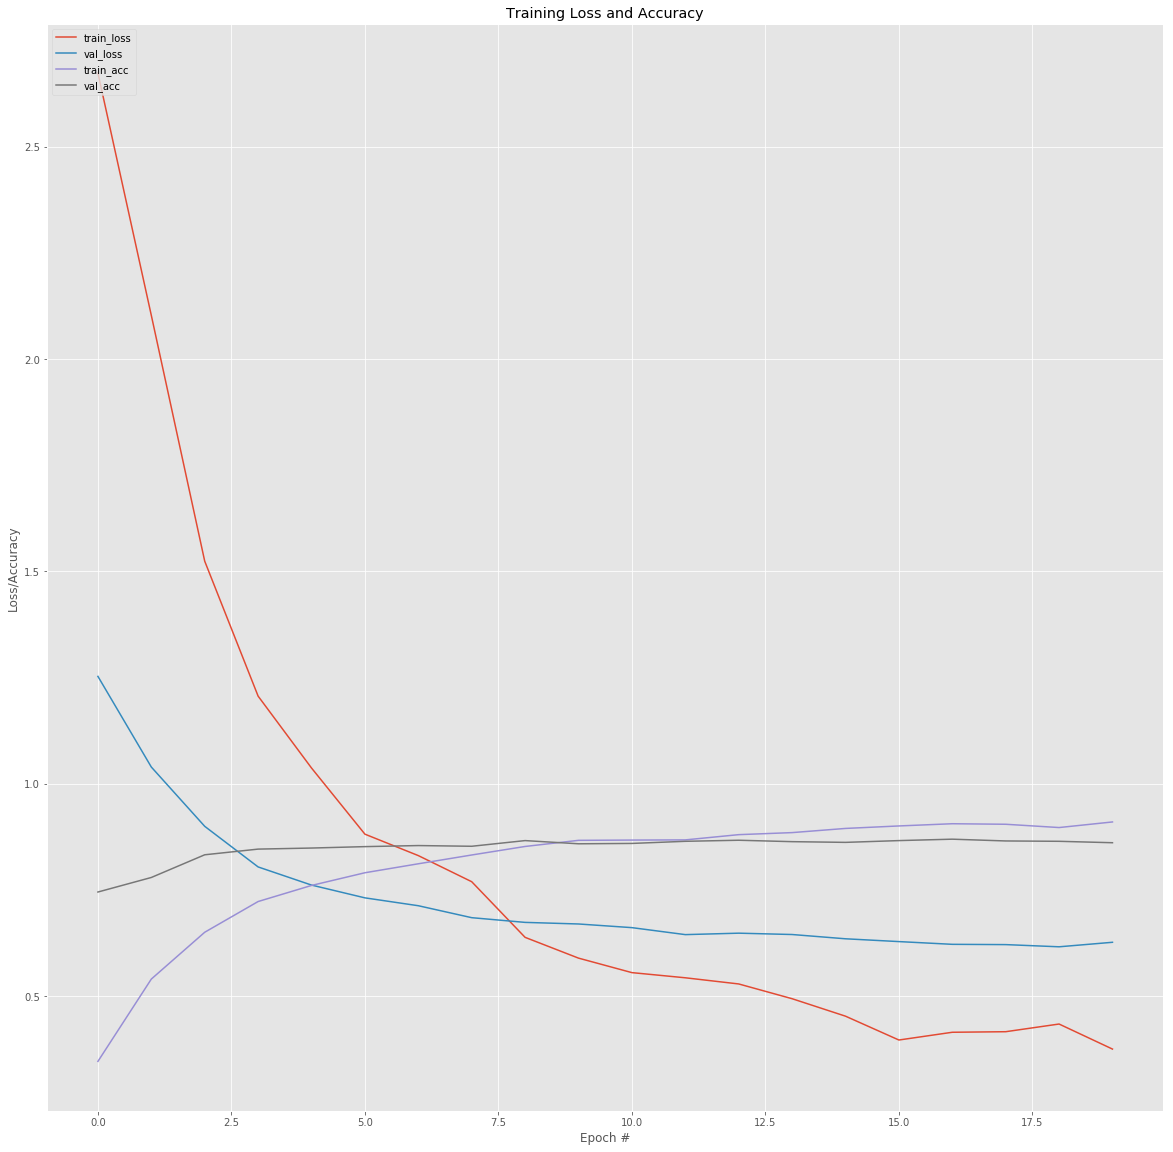

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline

plt.style.use("ggplot")
plt.figure(figsize=(20, 20))
plt.plot(np.arange(0, epochs), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, epochs), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, epochs), H.history["acc"], label="train_acc")
plt.plot(np.arange(0, epochs), H.history["val_acc"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper left")

From my point of view results can improve but are not that bad.

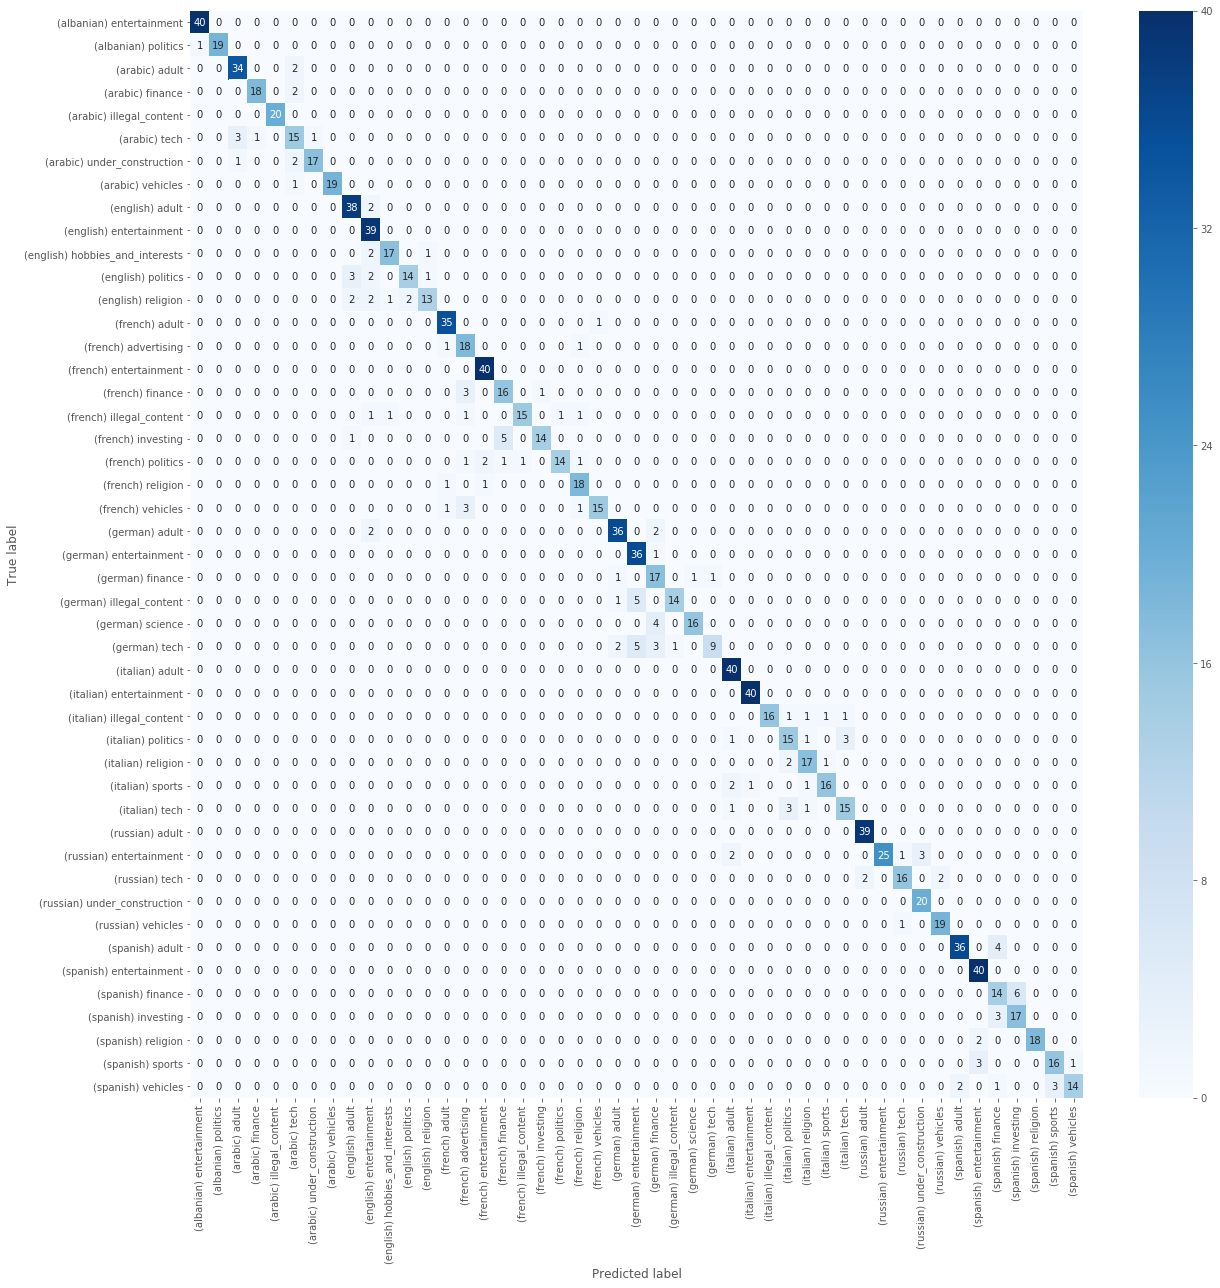

In [14]:
from sklearn.metrics import confusion_matrix
import seaborn as sn


Ypred = model.predict(train_test_matrix)
cm = confusion_matrix(test_lb.argmax(axis=1), Ypred.argmax(axis=1))

plt.figure(figsize=(20, 20))
sn.heatmap(cm, annot=True, cmap='Blues', fmt='g', xticklabels=np.asarray(lb.classes_),
           yticklabels=np.asarray(lb.classes_))
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()